# Mission

**Prêt à dépenser**, une société financière spécialisée dans les crédits à la consommation pour des individus sans historique de prêt, souhaite développer un outil de "scoring crédit" pour calculer la probabilité qu’un client rembourse son crédit.

L'objectif est de prédire la probabilité de remboursement d'un client et de classifier les demandes en crédit accordé ou refusé en utilisant un algorithme de classification.

La mission implique :

* Mise en œuvre d'une démarche MLOps en utilisant des outils Open Source :
  - MLFlow : tracking d'expérimentations, stockage centralisé.
  - Git : gestion de code.
  - Github :  partage de code.
  - Github Actions : Déploiement de l'API de manière continue.
  - Pytest : tests unitaires.
  - Evidently : Data drift en production.
* Construction du modèle de scoring : 
  - Prise en compte du déséquilibre des classes et du coût métier entre faux négatifs et faux positifs.
  - Optimisation des hyperparamètres.
  - Analyse des features qui contribuent le plus au modèle (feature importance locale et globale).
* Mise en production du Modèle de scoring :
  - Déploiement de l'API sur une plateforme Cloud (Azure ou autre)
  - Interface de test en utilisant Streamlit

# Importation des données

In [1]:
# Importation des librairies

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import seaborn as sns
import re

from sklearn.dummy import DummyClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn import under_sampling, over_sampling

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score, fbeta_score, confusion_matrix, classification_report

from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.dummy import DummyClassifier

from xgboost import XGBClassifier

from sklearn.base import clone

from hyperopt import hp, tpe, Trials, fmin

import joblib

import mlflow
import mlflow.sklearn

import shap
shap.initjs()

import time

Description des données :

* **application_(train|test)** : Les principales données d'entraînement et de test avec des informations sur chaque demande de prêt. Chaque prêt a sa propre ligne et est identifié par la caractéristique SK_ID_CURR. Les données d'entraînement viennent avec la TARGET indiquant 0 : le prêt a été remboursé ou 1 : le prêt n'a pas été remboursé.
* **bureau** : données concernant les crédits antérieurs du client auprès d'autres institutions financières. Chaque crédit précédent a sa propre ligne dans bureau, mais un prêt existant dans application_(train|test) peut avoir plusieurs crédits précédents.
* **bureau_balance** : données mensuelles concernant les crédits précédents dans bureau. Chaque ligne correspond à un mois de crédit précédent, et un crédit précédent unique peut avoir plusieurs lignes, une pour chaque mois de la durée du crédit.
* **previous_application** : demandes précédentes de prêts a Home Credit des clients qui ont des prêts dans les données de application_(train|test). Chaque prêt actuel dans les données de application_(train|test) peut avoir plusieurs prêts précédents. Chaque demande précédente a une ligne et est identifiée par la caractéristique SK_ID_PREV.
* **POS_CASH_BALANCE** : données mensuelles sur les prêts au point de vente ou en espèces que les clients ont eu avec Home Credit. Chaque ligne correspond à un mois d'un prêt au point de vente ou d'un prêt en espèces précédent, et un seul prêt précédent peut avoir plusieurs lignes.
* **credit_card_balance** : données mensuelles sur les cartes de crédit que les clients ont eu avec Home Credit. Chaque ligne correspond à un mois de solde de carte de crédit, et une seule carte de crédit peut avoir plusieurs lignes.
* **installments_payment** : historique des paiements pour les prêts précédents chez Home Credit. Il y a une ligne pour chaque paiement effectué et une ligne pour chaque paiement manqué.


Ce diagramme montre comment toutes les données sont liées:

![home_credit.png](home_credit.png)

Modeles : LightGBM, XGBoost, CatBoost
Metriques :
- ROC AUC, precision, recall, f1, matrice de confusion

# Exploration des données

In [2]:
# Training data
app_train = pd.read_csv('application_train.csv')
print('Training data shape: ', app_train.shape)
app_train.head()

Training data shape:  (307511, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


Les données d’entraînement contient 307511 lignes (chaque ligne correspondant à un prêt distinct) et 122 variables, y compris la TARGET (l’étiquette que nous voulons prédire).

In [3]:
# Testing data features
app_test = pd.read_csv('application_test.csv')
print('Testing data shape: ', app_test.shape)
app_test.head()

Testing data shape:  (48744, 121)


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


Les données de test contient 48744 lignes et 121 colonnes (ne comporte pas de colonne TARGET).

* Examinons la distribution de la colonne cible :

In [4]:
app_train['TARGET'].value_counts()

TARGET
0    282686
1     24825
Name: count, dtype: int64

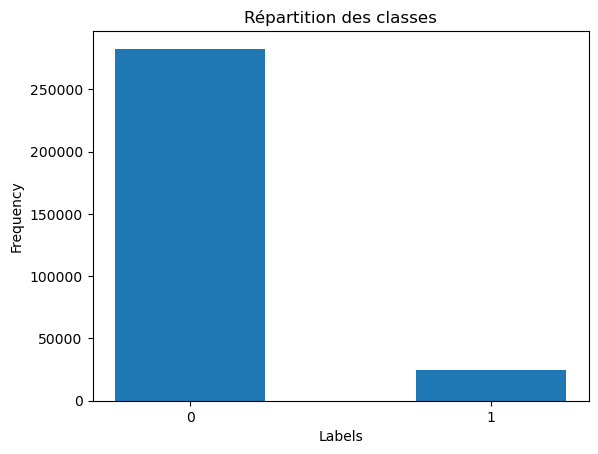

In [4]:
# Create a histogram with two bins (0 and 1)
app_train['TARGET'].plot.hist(bins=[-0.5, 0.5, 1.5], rwidth=0.5)

# Add labels and a title
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.title('Répartition des classes')

# Add labels to the bars
plt.xticks([0, 1], ['0', '1'])

# Show the plot
plt.show()

Nous constatons qu'il s'agit d'un problème de classe déséquilibrée. Il y a beaucoup plus de prêts qui ont été remboursés à temps que de prêts qui n'ont pas été remboursés. En modélisant notre problème, il faut prendre en compte ce déséquilibre.

* **Les types des colonnes :**

In [6]:
# Number of each type of column
app_train.dtypes.value_counts()

float64    65
int64      41
object     16
Name: count, dtype: int64

Examinons le nombre des valeurs uniques dans chacune des colonnes catégorielles.

In [7]:
# Number of unique classes in each object column
app_train.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

La plupart des variables catégorielles ont un nombre relativement petit de valeurs uniques.

* **Les doublons :**

Nous vérifions la présence d'éventuels doublons en utilisant 'SK_ID_CURR' comme identifiant unique :

In [8]:
# Check for duplicates in the SK_ID_CURR column
duplicates = app_train['SK_ID_CURR'].duplicated()

# Display rows where duplicates are found
duplicate_rows = app_train[duplicates]
print("Lignes avec des doublons dans SK_ID_CURR:")
duplicate_rows

Lignes avec des doublons dans SK_ID_CURR:


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR


Notre data train ne contient pas de doublons

* **Les valeurs manquantes :**

Nous examinons le nombre et le pourcentage de valeurs manquantes dans chaque colonne.

In [9]:
# Function to calculate missing values by column# Funct 
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Valeurs manquantes', 1 : '% des valeurs manquantes'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% des valeurs manquantes', ascending=False).round(1)
        
        # Print some summary information
        print ("Le dataframe selectionné contient " + str(df.shape[1]) + " colonnes.\n"      
            "Il y a " + str(mis_val_table_ren_columns.shape[0]) +
              " colonnes qui contient des valeurs manquantes.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [10]:
# Missing values statistics
missing_values = missing_values_table(app_train)
missing_values.head(20)

Le dataframe selectionné contient 122 colonnes.
Il y a 67 colonnes qui contient des valeurs manquantes.


,Valeurs manquantes,% des valeurs manquantes
COMMONAREA_MEDI,214865,69.9
COMMONAREA_AVG,214865,69.9
COMMONAREA_MODE,214865,69.9
NONLIVINGAPARTMENTS_MEDI,213514,69.4
NONLIVINGAPARTMENTS_MODE,213514,69.4
NONLIVINGAPARTMENTS_AVG,213514,69.4
FONDKAPREMONT_MODE,210295,68.4
LIVINGAPARTMENTS_MODE,210199,68.4
LIVINGAPARTMENTS_MEDI,210199,68.4
LIVINGAPARTMENTS_AVG,210199,68.4


Pour construire nos modèles, nous devrons imputer ces valeurs manquantes ou bien une autre option serait de supprimer les colonnes avec un pourcentage élevé de valeurs manquantes, bien qu'il soit impossible de savoir à l'avance si ces colonnes seront utiles à notre modèle. Par conséquent, nous conserverons toutes les colonnes pour l'instant.

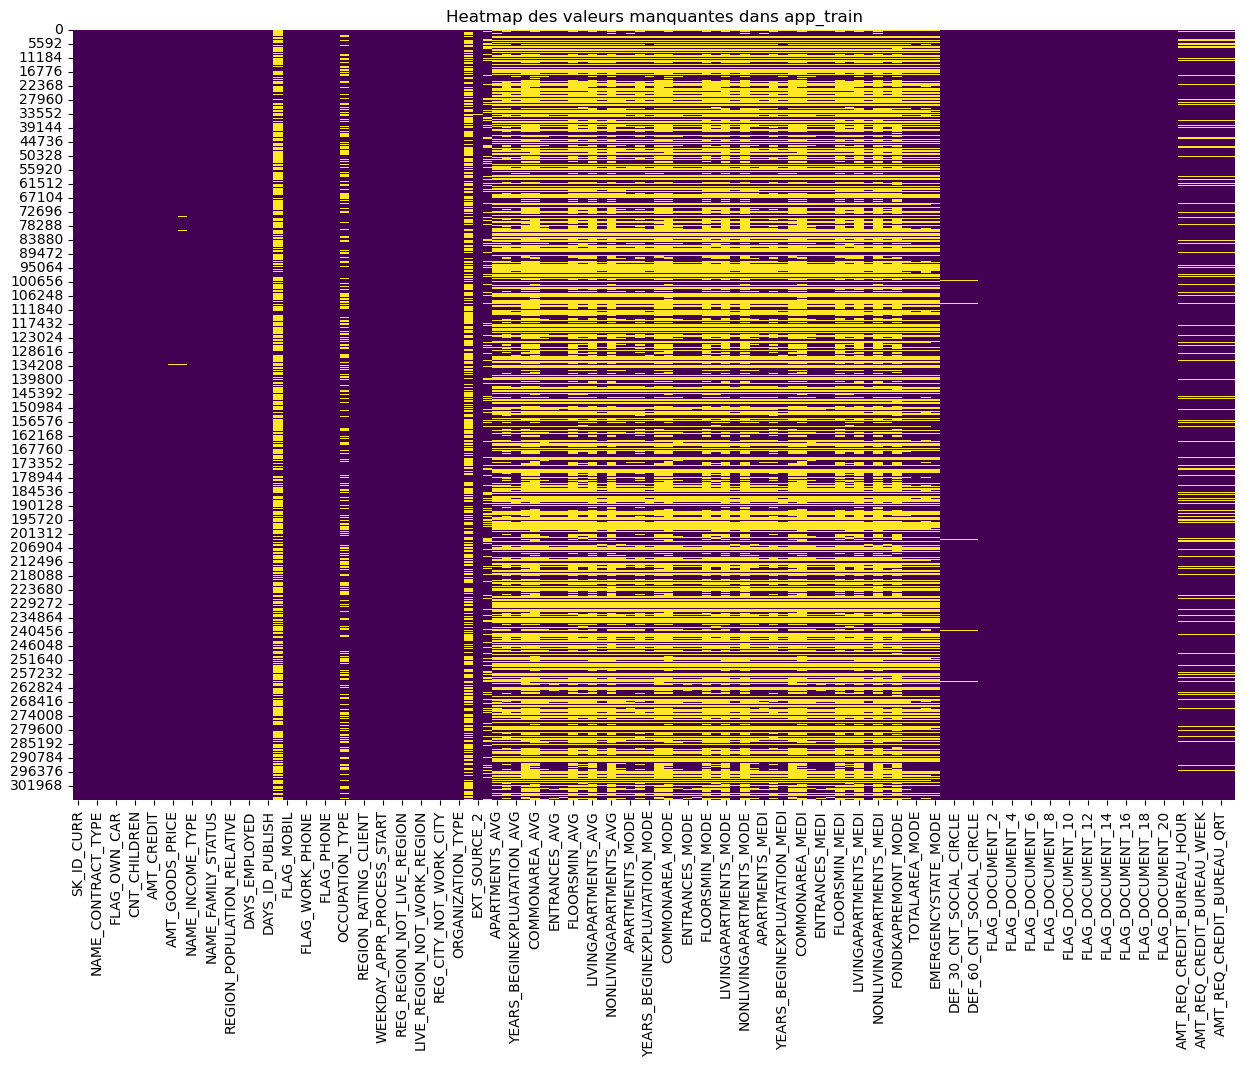

In [11]:
# Create a heatmap of missing values
plt.figure(figsize=(15, 10))
sns.heatmap(app_train.isnull(), cbar=False, cmap='viridis')

# Add additional information
plt.title('Heatmap des valeurs manquantes dans app_train')
plt.show()

* **Les valeurs aberrantes :**

In [4]:
# Display options
pd.set_option('display.max_columns', 110)

In [5]:
app_train.describe()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,307511.000000,307511.000000,307511.000000,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,104582.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307509.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,134133.000000,3.068510e+05,246546.000000,151450.00000,127568.000000,157504.000000,103023.000000,92646.000000,143620.000000,152683.000000,154491.000000,98869.000000,124921.000000,97312.000000,153161.000000,93997.000000,137829.000000,151450.000000,127568.000000,157504.000000,103023.000000,92646.000000,143620.000000,152683.000000,154491.000000,98869.000000,124921.000000,97312.000000,153161.000000,93997.000000,137829.000000,151450.000000,127568.000000,157504.000000,103023.000000,92646.000000,143620.000000,152683.000000,154491.000000,98869.000000,124921.000000,97312.000000,153161.000000,93997.000000,137829.000000,159080.000000,306490.000000,306490.000000,306490.000000,306490.000000,307510.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.00000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000
mean,278180.518577,0.080729,0.417052,1.687979e+05,5.990260e+05,27108.573909,5.383962e+05,0.020868,-16036.995067,63815.045904,-4986.120328,-2994.202373,12.061091,0.999997,0.819889,0.199368,0.998133,0.281066,0.056720,2.152665,2.052463,2.031521,12.063419,0.015144,0.050769,0.040659,0.078173,0.230454,0.179555,0.502130,5.143927e-01,0.510853,0.11744,0.088442,0.977735,0.752471,0.044621,0.078942,0.149725,0.226282,0.231894,0.066333,0.100775,0.107399,0.008809,0.028358,0.114231,0.087543,0.977065,0.759637,0.042553,0.074490,0.145193,0.222315,0.228058,0.064958,0.105645,0.105975,0.008076,0.027022,0.117850,0.087955,0.97

* Les jours sont négatifs pour les variables DAYS_
* La valeur max pour la colonne 'DAYS_EMPLOYED' est anormale (max = 365243)

In [8]:
app_train['DAYS_EMPLOYED'].describe()

count    307511.000000
mean      63815.045904
std      141275.766519
min      -17912.000000
25%       -2760.000000
50%       -1213.000000
75%        -289.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

La valeur maximale est l'équivalent d'environ 1000 ans !

Text(0.5, 0, 'Days Employment')

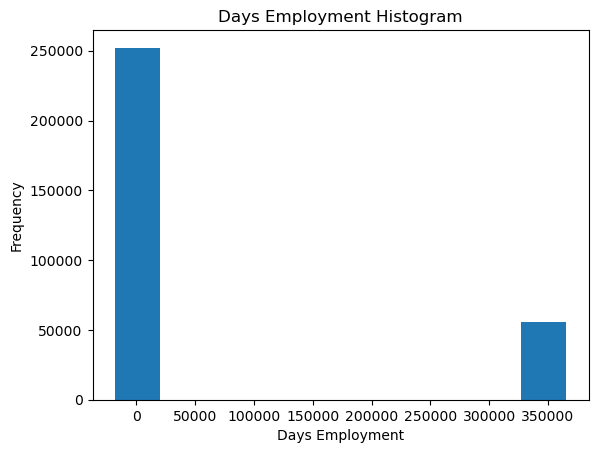

In [7]:
app_train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram')
plt.xlabel('Days Employment')

In [6]:
anom = app_train[app_train['DAYS_EMPLOYED'] == 365243]
print('Il y a %d valeurs aberrantes dans DAYS_EMPLOYED' % len(anom))

Il y a 55374 valeurs aberrantes dans DAYS_EMPLOYED


Toutes les anomalies ont exactement la même valeur, peut être que tous ces prêts auraient quelque chose en commun.

Remplissons les valeurs anormales avec des nan et créerons ensuite une nouvelle colonne booléenne indiquant si la valeur était anormale ou non.

In [7]:
# Create an anomalous flag column
app_train['DAYS_EMPLOYED_ANOM'] = app_train["DAYS_EMPLOYED"] == 365243

# Replace the anomalous values with nan
app_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

Text(0.5, 0, 'Days Employment')

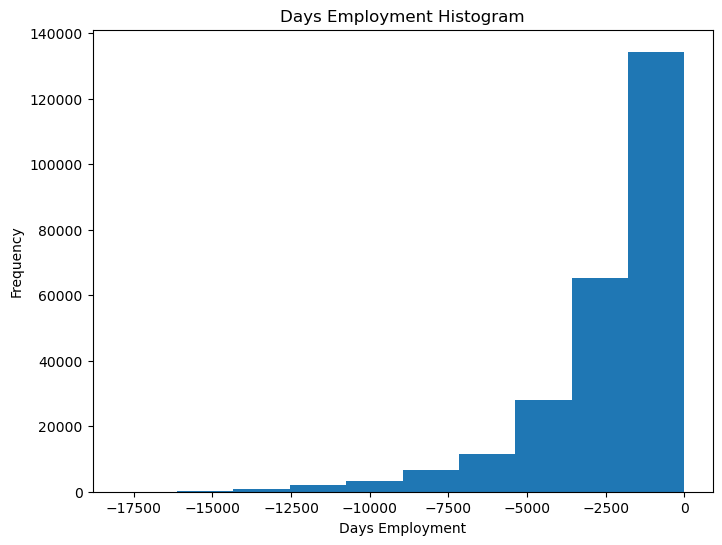

In [8]:
plt.figure(figsize=(8, 6))
app_train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram')
plt.xlabel('Days Employment')

La distribution semble être normale.

Il faut créer la nouvelle colonne et de remplir la colonne existante avec des nan dans les données de test également.

In [8]:
app_test['DAYS_EMPLOYED_ANOM'] = app_test["DAYS_EMPLOYED"] == 365243
app_test["DAYS_EMPLOYED"].replace({365243: np.nan}, inplace = True)

print('Il y a %d valeurs aberrantes dans DAYS_EMPLOYED des données de test' % app_test["DAYS_EMPLOYED_ANOM"].sum())

Il y a 9274 valeurs aberrantes dans DAYS_EMPLOYED des données de test


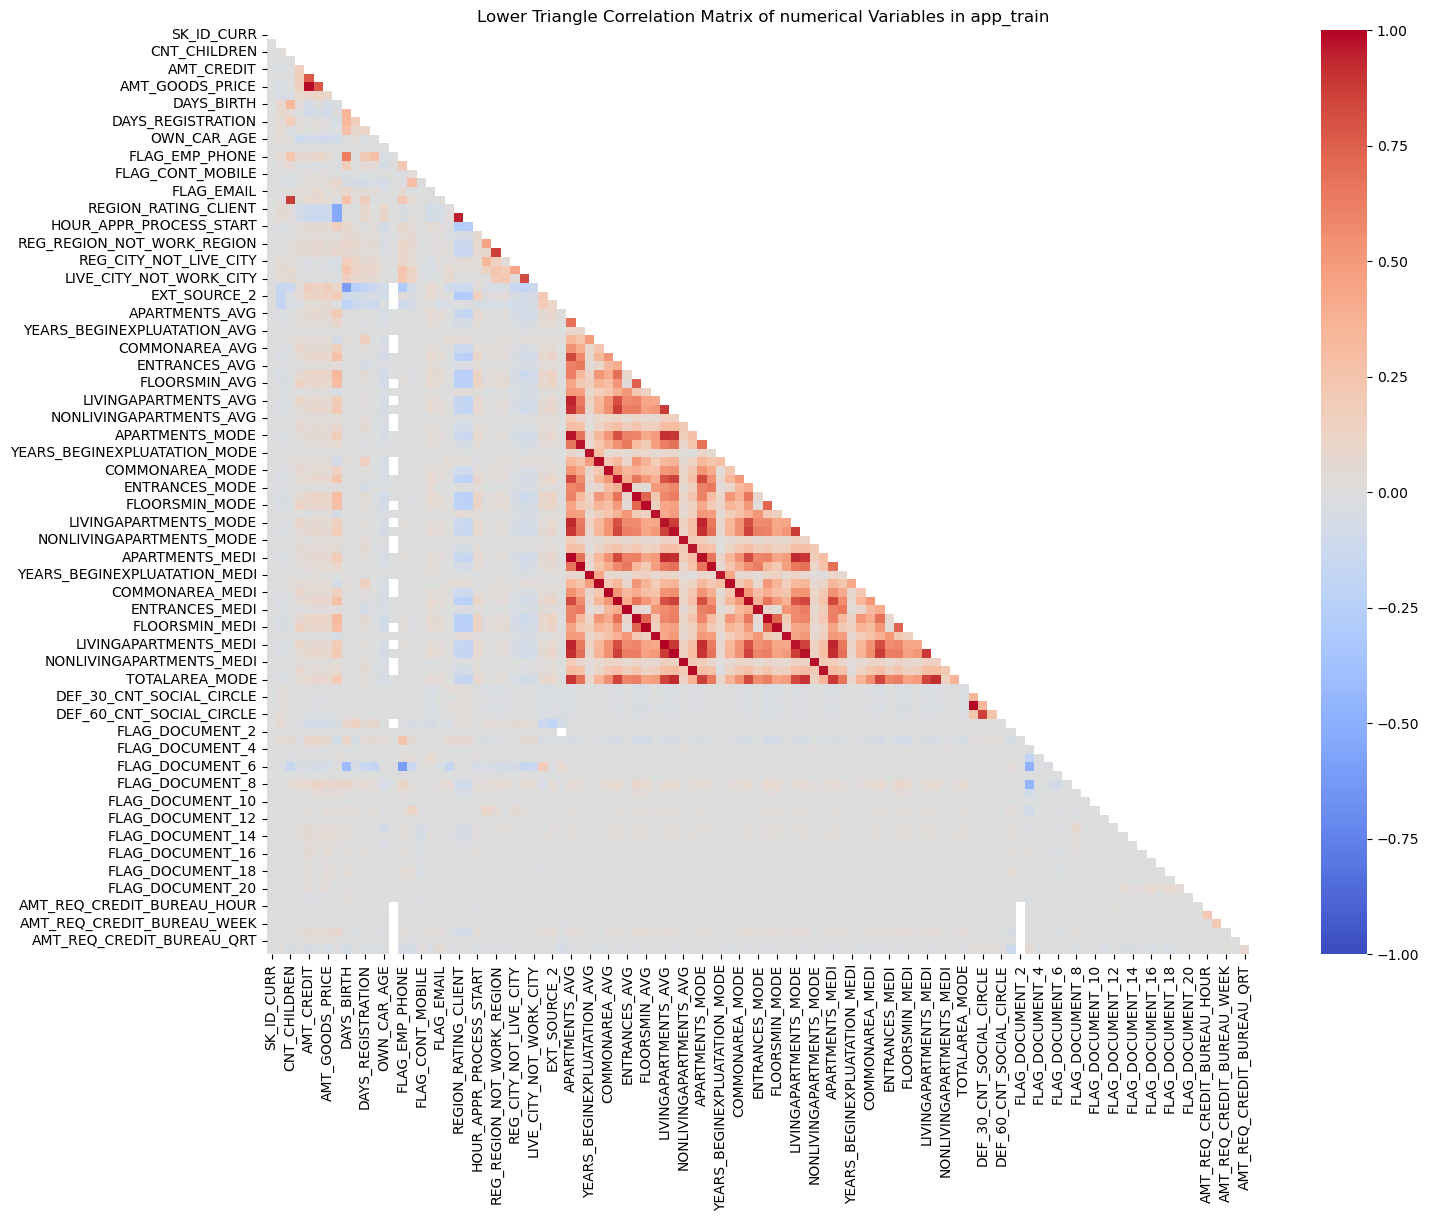

In [18]:
# Exclude non numeric columns 
numeric_columns = app_train.select_dtypes(include=[np.number]).columns
numeric_data = app_train[numeric_columns]

# Calculate the correlation matrix
correlation_matrix = numeric_data.corr()

# Create a mask for the lower triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Set the size of the plot
plt.figure(figsize=(16, 12))

# Create a heatmap of the lower triangle of the correlation matrix
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=False, fmt=".2f", vmin=-1, vmax=1, mask=mask)

# Add a title to the plot
plt.title('Lower Triangle Correlation Matrix of numerical Variables in app_train')

# Show the plot
plt.show()

In [21]:
# Filter pairs with correlation coefficient greater than 0.80
high_correlation_pairs = (correlation_matrix[abs(correlation_matrix) > 0.80]
                          .stack()
                          .reset_index()
                          .rename(columns={0: 'correlation'}))

# Filter out pairs with correlation coefficient of 1 (self-correlation)
high_correlation_pairs = high_correlation_pairs[high_correlation_pairs['correlation'] < 1]

# Sort the DataFrame in descending order by correlation coefficient
high_correlation_pairs_sorted = high_correlation_pairs.sort_values(by='correlation', ascending=False)

# Display the sorted table
print("Pairs with correlation coefficient > 0.80 (sorted in descending order):")
high_correlation_pairs_sorted

Pairs with correlation coefficient > 0.80 (sorted in descending order):


,level_0,level_1,correlation
63,YEARS_BUILD_AVG,YEARS_BUILD_MEDI,0.998495
219,YEARS_BUILD_MEDI,YEARS_BUILD_AVG,0.998495
297,OBS_60_CNT_SOCIAL_CIRCLE,OBS_30_CNT_SOCIAL_CIRCLE,0.998490
294,OBS_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,0.998490
87,FLOORSMIN_AVG,FLOORSMIN_MEDI,0.997241
...,...,...,...
229,ELEVATORS_MEDI,APARTMENTS_MODE,0.808858
152,ELEVATORS_MODE,LIVINGAPARTMENTS_MODE,0.807601
174,LIVINGAPARTMENTS_MODE,ELEVATORS_MODE,0.807601
123,APARTMENTS_MODE,ELEVATORS_AVG,0.806009


* **Les correlations avec la cible:**

In [10]:
from scipy.stats import chi2_contingency
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

cramers_v(app_train['TARGET'], app_train['DAYS_BIRTH'])

0.07392097266373665

In [19]:
# Find correlations with the target and sort
correlations = numeric_data.corr()['TARGET'].sort_values()

# Display correlations
print('Corrélations les plus positives:\n', correlations.tail(15))
print('\nCorrélations les plus négatives:\n', correlations.head(15))

Corrélations les plus positives:
 DEF_30_CNT_SOCIAL_CIRCLE       0.032248
LIVE_CITY_NOT_WORK_CITY        0.032518
OWN_CAR_AGE                    0.037612
DAYS_REGISTRATION              0.041975
FLAG_DOCUMENT_3                0.044346
REG_CITY_NOT_LIVE_CITY         0.044395
FLAG_EMP_PHONE                 0.045982
REG_CITY_NOT_WORK_CITY         0.050994
DAYS_ID_PUBLISH                0.051457
DAYS_LAST_PHONE_CHANGE         0.055218
REGION_RATING_CLIENT           0.058899
REGION_RATING_CLIENT_W_CITY    0.060893
DAYS_EMPLOYED                  0.074958
DAYS_BIRTH                     0.078239
TARGET                         1.000000
Name: TARGET, dtype: float64

Corrélations les plus négatives:
 EXT_SOURCE_3                 -0.178919
EXT_SOURCE_2                 -0.160472
EXT_SOURCE_1                 -0.155317
FLOORSMAX_AVG                -0.044003
FLOORSMAX_MEDI               -0.043768
FLOORSMAX_MODE               -0.043226
AMT_GOODS_PRICE              -0.039645
REGION_POPULATION_RELATIVE   

* La corrélation DAYS_BIRTH est la plus positive.

La corrélation est positive, mais la valeur de cette caractéristique est négative, ce qui signifie qu’à mesure que le client vieillit, il est moins susceptible de faire défaut sur son prêt (TARGET == 0)

En prenant la valeur absolue de cette caractéristique, la corrélation sera alors négative :

In [9]:
# Find the correlation of the positive days since birth and target
app_train['DAYS_BIRTH'] = abs(app_train['DAYS_BIRTH'])
app_train['DAYS_BIRTH'].corr(app_train['TARGET'])

-0.07823930830982709

Plus les clients vieillissent, ils ont tendance à rembourser leurs prêts à temps.

Pour examiner cette variable, nous pouvons faire un histogramme de l’âge. Nous mettrons l’axe des x en années pour rendre le graphique un peu plus compréhensible.

Text(0, 0.5, 'Nombre')

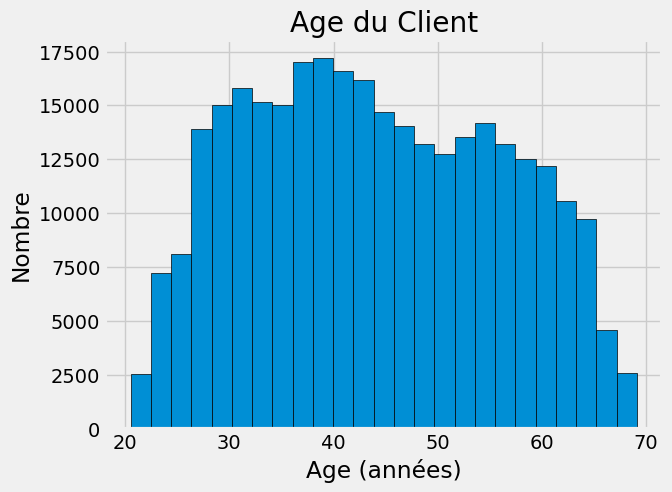

In [10]:
# Set the style of plots
plt.style.use('fivethirtyeight')

# Plot the distribution of ages in years
plt.hist(app_train['DAYS_BIRTH'] / 365, edgecolor = 'k', bins = 25)
plt.title('Age du Client'); plt.xlabel('Age (années)'); plt.ylabel('Nombre')

La distribution de l'Age ne nous dit pas grand-chose, il n'y a pas de valeurs aberrantes car tous les âges sont raisonnables.

Pour visualiser l'effet de l'Age sur la cible, nous allons réaliser un tracé d'estimation de la densité du noyau (KDE) coloré par la valeur de la cible.

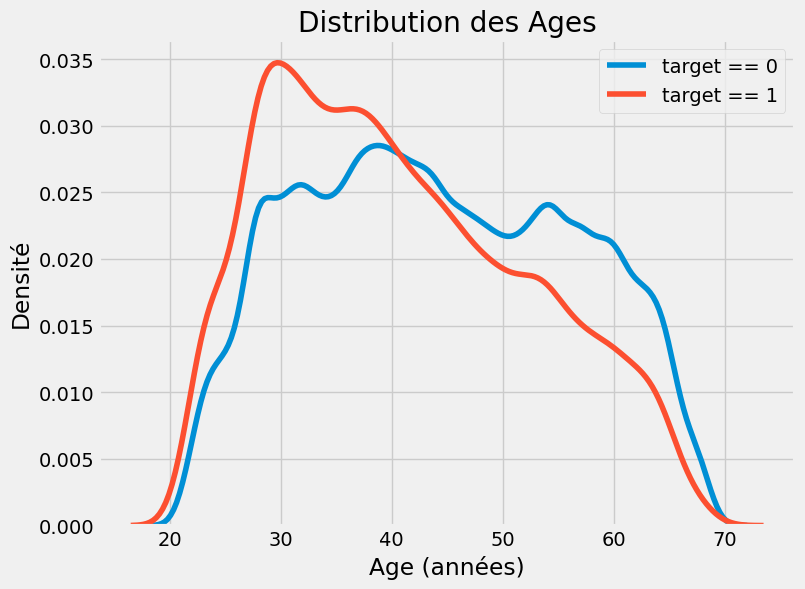

In [28]:
plt.figure(figsize=(8, 6))

# KDE plot of loans that were repaid on time
sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, 'DAYS_BIRTH'] / 365, label='target == 0')

# KDE plot of loans which were not repaid on time
sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, 'DAYS_BIRTH'] / 365, label='target == 1')

# Labeling of plot
plt.xlabel('Age (années)')
plt.ylabel('Densité')
plt.title('Distribution des Ages')

# Add legend
plt.legend()

# Show the plot
plt.show()

Il n'y a pas de différence significative entre les deux distributions

* Les variables ayant les corrélations négatives les plus fortes avec la cible sont les variables EXT_

Ces 3 variables EXT_SOURCE_1, EXT_SOURCE_2 et EXT_SOURCE_3. Selon la documentation, ces caractéristiques représentent un "score normalisé provenant d’une source de données externe".
Il peut s’agir d’une sorte de cote de crédit cumulative établie à l’aide de nombreuses sources de données.

In [42]:
# Extract the EXT_SOURCE variables and show correlations
ext_data = app_train[['TARGET',
                      'EXT_SOURCE_1',
                      'EXT_SOURCE_2', 
                      'EXT_SOURCE_3',
                      'DAYS_BIRTH']]
ext_data_corrs = ext_data.corr()
ext_data_corrs

,TARGET,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH
TARGET,1.000000,-0.155317,-0.160472,-0.178919,-0.078239
EXT_SOURCE_1,-0.155317,1.000000,0.213982,0.186846,0.600610
EXT_SOURCE_2,-0.160472,0.213982,1.000000,0.109167,0.091996
EXT_SOURCE_3,-0.178919,0.186846,0.109167,1.000000,0.205478
DAYS_BIRTH,-0.078239,0.600610,0.091996,0.205478,1.000000


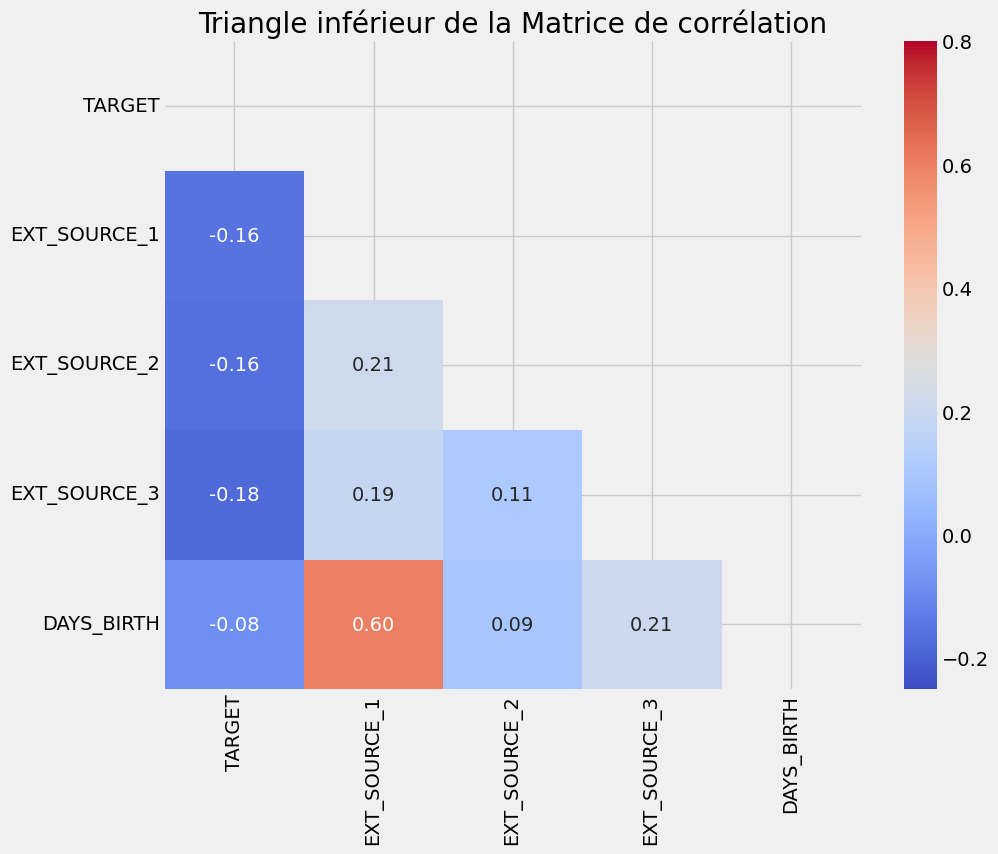

In [33]:
# Calculate the correlation matrix
correlation_matrix = ext_data.corr()

# Create a mask for the lower triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Set the size of the plot
plt.figure(figsize=(10, 8))

# Create a heatmap of the lower triangle of the correlation matrix
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=True, fmt=".2f", vmin=-0.25, vmax=0.80, mask=mask)

# Add a title to the plot
plt.title('Triangle inférieur de la Matrice de corrélation')

# Show the plot
plt.show()

Les trois caractéristiques EXT_SOURCE ont des corrélations négatives avec la cible, indiquant qu’à mesure que la valeur de l’EXT_SOURCE augmente, le client est plus susceptible de rembourser le prêt. Nous pouvons également voir que DAYS_BIRTH est positivement corrélé avec EXT_SOURCE_1, indiquant qu’un des facteurs de ce score est peut-être l’âge du client.

Regardons la distribution de chacune de ces caractéristiques colorées par la valeur de la cible. Cela nous permettra de visualiser l’effet de cette variable sur la cible.

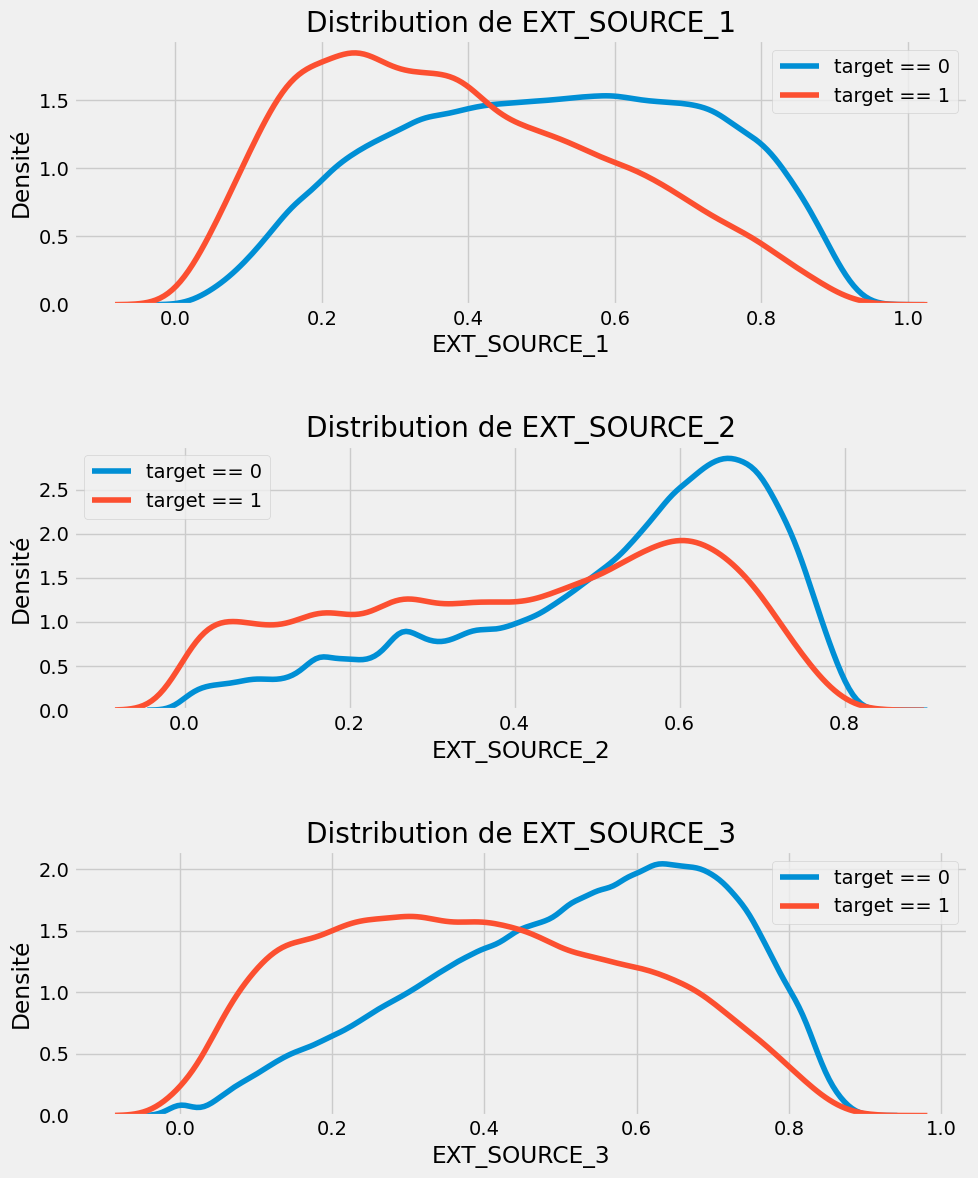

In [43]:
plt.figure(figsize = (10, 12))

# iterate through the sources
for i, source in enumerate(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']):
    
    # create a new subplot for each source
    plt.subplot(3, 1, i + 1)
    # plot repaid loans
    sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, source], label = 'target == 0')
    # plot loans that were not repaid
    sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, source], label = 'target == 1')
    
    # Label the plots
    plt.title('Distribution de %s' % source)
    plt.xlabel('%s' % source); plt.ylabel('Densité')
    
    # Add legend
    plt.legend()
    
plt.tight_layout(h_pad = 3)

EXT_SOURCE_3 affiche la plus grande différence entre les valeurs de la cible. Nous pouvons clairement voir que cette caractéristique a une certaine relation avec la probabilité qu’un demandeur rembourse un prêt. La relation n’est pas très forte, elles sont toutes considérées comme très faibles.

# Feature Engineering

* **Création de nouvelles variables :**

Nous pouvons créer quelques caractéristiques qui tentent de capturer ce que nous pensons être important pour déterminer si un client fera défaut sur un prêt.

* CREDIT_INCOME_PERCENT : le pourcentage du montant du crédit par rapport au revenu d'un client
* ANNUITY_INCOME_PERCENT : le pourcentage de l'annuité du prêt par rapport au revenu d'un client
* CREDIT_TERM : la durée du paiement en mois
* DAYS_EMPLOYED_PERCENT : le pourcentage des jours employés par rapport à l'âge du client

In [11]:
app_train_domain = app_train.copy()
app_test_domain = app_test.copy()

#Features train data
app_train_domain['CREDIT_INCOME_PERCENT'] = app_train_domain['AMT_CREDIT'] / app_train_domain['AMT_INCOME_TOTAL']
app_train_domain['ANNUITY_INCOME_PERCENT'] = app_train_domain['AMT_ANNUITY'] / app_train_domain['AMT_INCOME_TOTAL']
app_train_domain['CREDIT_TERM'] = app_train_domain['AMT_ANNUITY'] / app_train_domain['AMT_CREDIT']
app_train_domain['DAYS_EMPLOYED_PERCENT'] = app_train_domain['DAYS_EMPLOYED'] / app_train_domain['DAYS_BIRTH']

#Features Test data
app_test_domain['CREDIT_INCOME_PERCENT'] = app_test_domain['AMT_CREDIT'] / app_test_domain['AMT_INCOME_TOTAL']
app_test_domain['ANNUITY_INCOME_PERCENT'] = app_test_domain['AMT_ANNUITY'] / app_test_domain['AMT_INCOME_TOTAL']
app_test_domain['CREDIT_TERM'] = app_test_domain['AMT_ANNUITY'] / app_test_domain['AMT_CREDIT']
app_test_domain['DAYS_EMPLOYED_PERCENT'] = app_test_domain['DAYS_EMPLOYED'] / app_test_domain['DAYS_BIRTH']

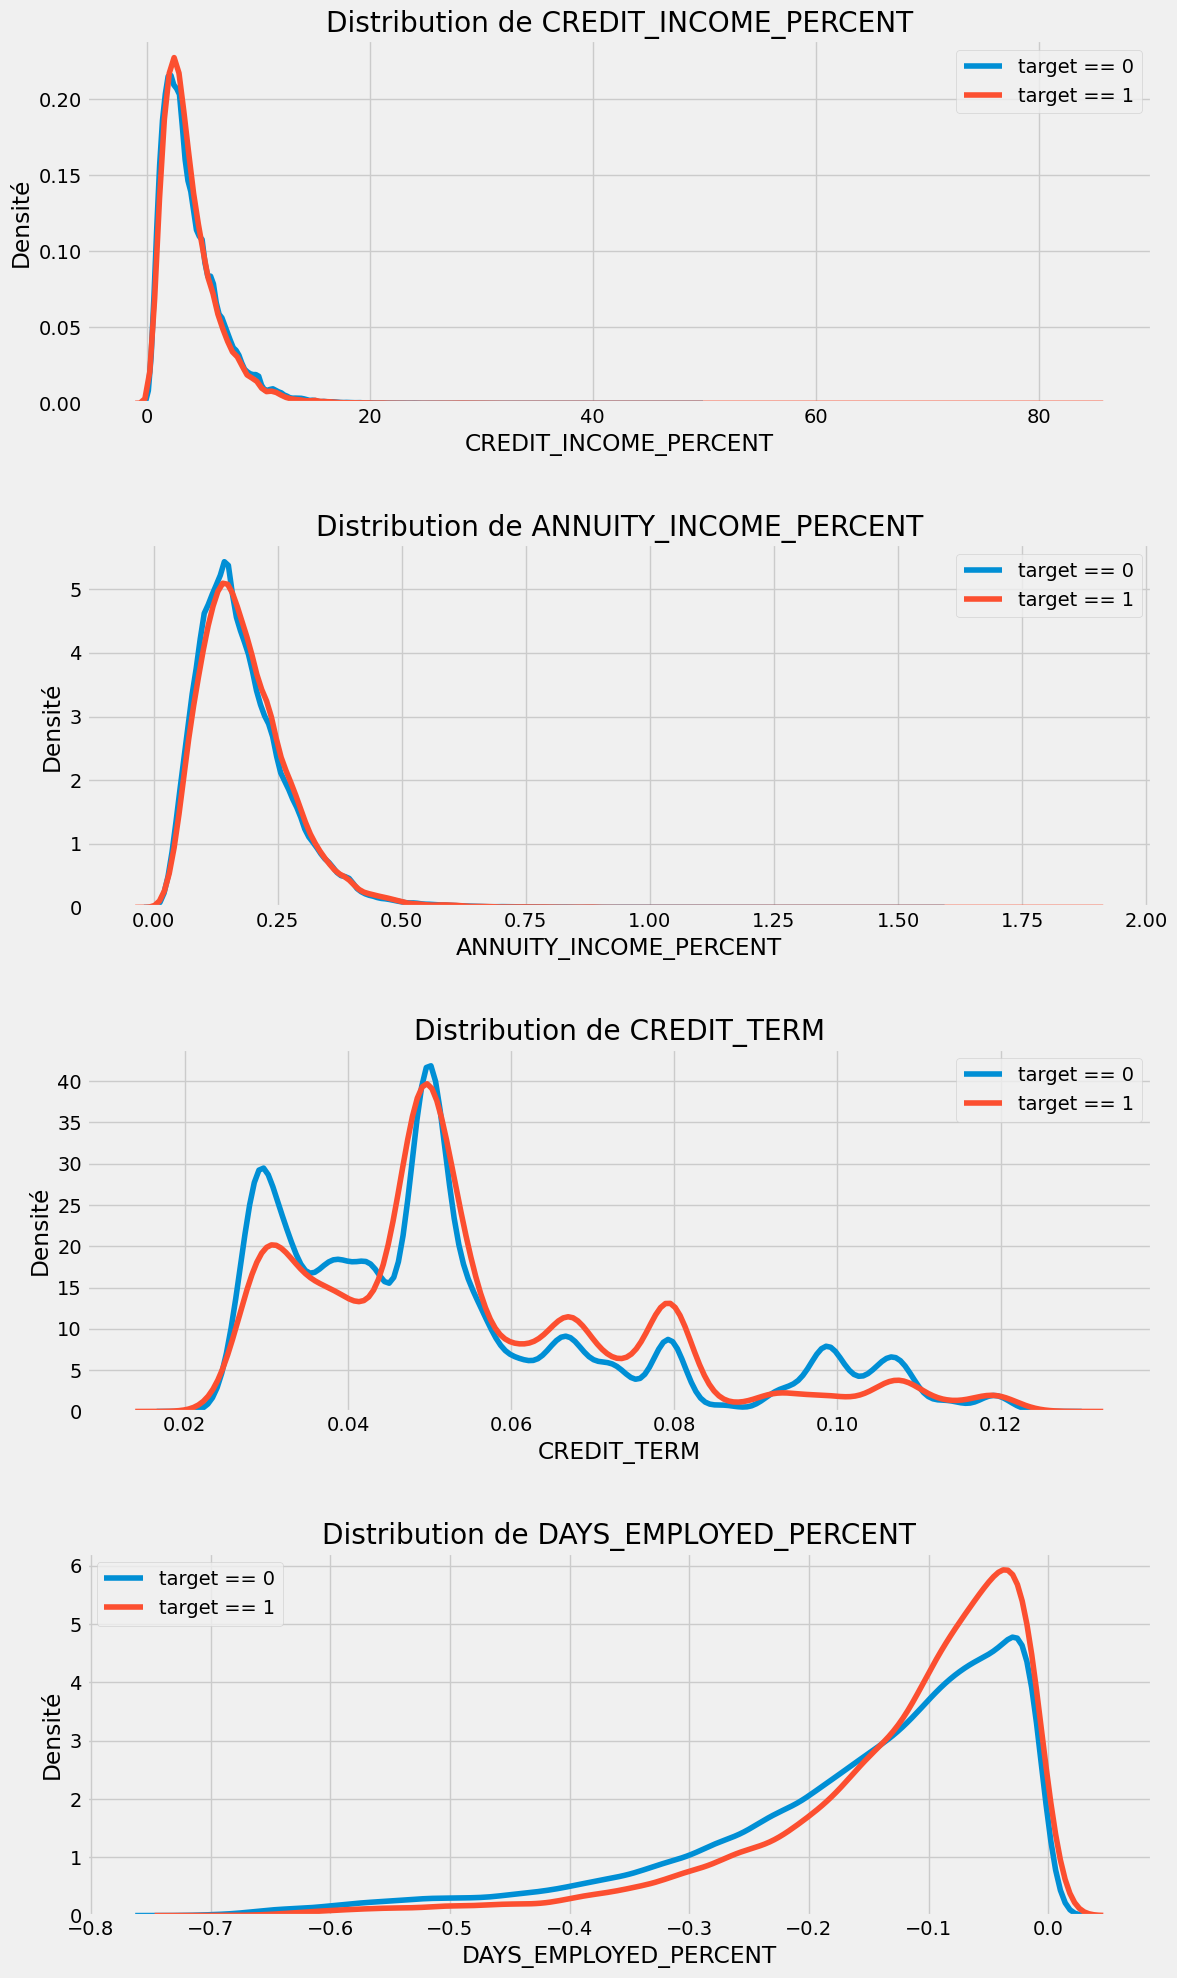

In [30]:
plt.figure(figsize = (12, 20))
# iterate through the new features
for i, feature in enumerate(['CREDIT_INCOME_PERCENT',
                             'ANNUITY_INCOME_PERCENT',
                             'CREDIT_TERM',
                             'DAYS_EMPLOYED_PERCENT']):
    
    # create a new subplot for each source
    plt.subplot(4, 1, i + 1)
    # plot repaid loans
    sns.kdeplot(app_train_domain.loc[app_train_domain['TARGET'] == 0, feature], label = 'target == 0')
    # plot loans that were not repaid
    sns.kdeplot(app_train_domain.loc[app_train_domain['TARGET'] == 1, feature], label = 'target == 1')
    
    # Label the plots
    plt.title('Distribution de %s' % feature)
    plt.xlabel('%s' % feature); plt.ylabel('Densité')
    
    # Add legend
    plt.legend()
    
plt.tight_layout(h_pad = 3)

Il est difficile de dire à l'avance si ces nouvelles caractéristiques seront utiles. La seule façon de le savoir avec certitude est de les essayer !

* **L'encodage des variables catégorielles :**

Pour toute variable catégorielle avec 2 catégories uniques, nous utiliserons LabelEncoder, et pour toute variable catégorielle avec plus de 2 catégories uniques, nous utiliserons le one-hot encoding.

In [21]:
# Create a label encoder object
le = LabelEncoder()
le_count = 0

# Iterate through the columns
for col in app_train:
    if app_train[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(app_train[col].unique())) <= 2:
            # Train on the training data
            le.fit(app_train[col])
            # Transform both training and testing data
            app_train[col] = le.transform(app_train[col])
            app_test[col] = le.transform(app_test[col])
            
            # Keep track of how many columns were label encoded
            le_count += 1
            
print('%d colonnes ont été codées par LabelEncoder.' % le_count)

3 colonnes ont été codées par LabelEncoder.


Nous utilisons le one-hot encoding pour toutes les colonnes catégorielles, qu'elles aient deux catégories uniques ou plus. Cela inclut également les variables catégorielles binaires.

In [20]:
# one-hot encoding of categorical variables
app_train = pd.get_dummies(app_train)
app_test = pd.get_dummies(app_test)

print('Training Features shape: ', app_train.shape)
print('Testing Features shape: ', app_test.shape)

Training Features shape:  (307511, 247)
Testing Features shape:  (48744, 243)


Il doit y avoir les mêmes colonnes dans les données d'entraînement et de test. Le one-hot encoding a créé plus de colonnes dans les données d'entraînement car il y avait des variables catégorielles avec des catégories non représentées dans les données de test.

Nous devons aligner les deux dataframes :

In [21]:
train_labels = app_train['TARGET']

# Align the training and testing data, keep only columns present in both dataframes
app_train, app_test = app_train.align(app_test, join = 'inner', axis = 1)

# Add the target back in
app_train['TARGET'] = train_labels

print('Training Features shape: ', app_train.shape)
print('Testing Features shape: ', app_test.shape)

Training Features shape:  (307511, 244)
Testing Features shape:  (48744, 243)


Les données d’entraînement et de test ont maintenant les mêmes colonnes.

# Modélisation

In [12]:
# Split the data into training and test sets
X = app_train.drop('TARGET', axis=1)
y = app_train['TARGET']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
# Define the column transformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', MinMaxScaler())
        ]), selector(dtype_include='number')),  # Selects numerical features
        ('cat', OneHotEncoder(), selector(dtype_include='object'))  # Selects categorical features
    ])

## DummyClassifier

2024/02/20 10:57:01 INFO mlflow.tracking.fluent: Experiment with name 'Dummy Classifier' does not exist. Creating a new experiment.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


AUC ROC: 0.5
Accuracy: 0.9195323805342829
Confusion Matrix:
[[56554     0]
 [ 4949     0]]
Classification Report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56554
           1       0.00      0.00      0.00      4949

    accuracy                           0.92     61503
   macro avg       0.46      0.50      0.48     61503
weighted avg       0.85      0.92      0.88     61503



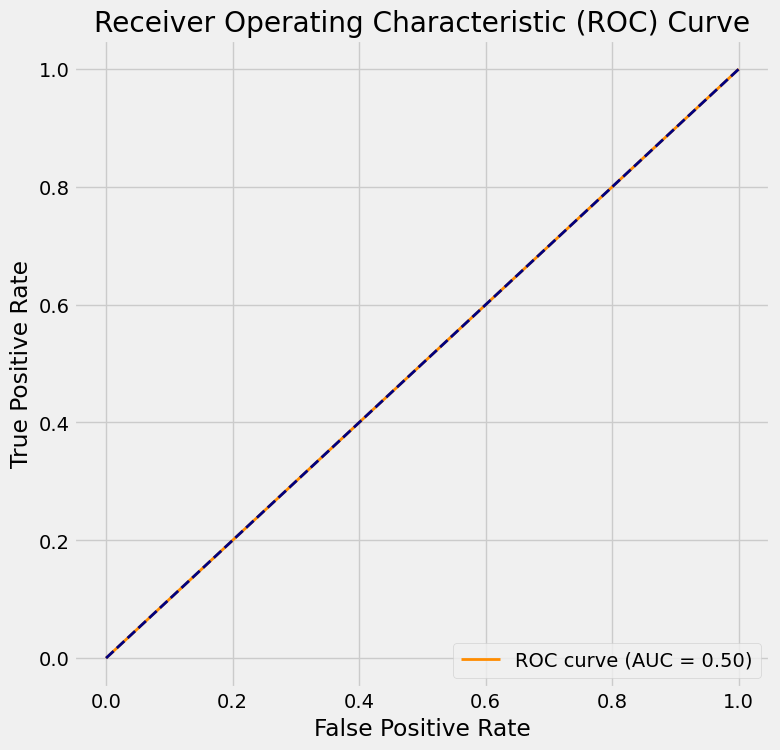

Setuptools is replacing distutils.


In [17]:
# Define the pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    #('imputer', SimpleImputer(strategy='median')),
    ('classifier', DummyClassifier(strategy='most_frequent', random_state=42))
])

# Name of the experiment
experiment_name = "Dummy Classifier"

# Set the experiment name
mlflow.set_experiment(experiment_name)

# Log the model parameters in MLFlow
with mlflow.start_run(run_name="dummy_baseline"):
    
    # Log specific parameters for this experiment
    mlflow.log_param("imputer_strategy", "median")
    mlflow.log_param("scaler", "MinMaxScaler")
    mlflow.log_param("classifier", "DummyClassifier")
    
    # Train the model
    pipeline.fit(X_train, y_train)
    
    # Predict on the test set
    y_pred_proba = pipeline.predict_proba(X_test)[:, 1]
    y_pred = pipeline.predict(X_test)

    # Calculate and print various metrics
    auc_roc = roc_auc_score(y_test, y_pred_proba)
    accuracy = accuracy_score(y_test, y_pred)
    #precision = precision_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    classif_report = classification_report(y_test, y_pred)
    
    print(f'AUC ROC: {auc_roc}')
    print(f'Accuracy: {accuracy}')
    #print(f'Precision: {precision}')
    print('Confusion Matrix:')
    print(conf_matrix)
    print('Classification Report:')
    print(classif_report)

    # Log the metrics in MLFlow
    mlflow.log_metric("AUC ROC", auc_roc)
    mlflow.log_metric("Accuracy", accuracy)
    
    # Plot ROC Curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 8))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")  
    # save the plot
    plt.savefig("roc_curve.png")
    # Show the plot
    plt.show()
    plt.close()
    
    # Log ROC Curve as an artifact
    mlflow.log_artifact("roc_curve.png", "roc_curve.png")
    
    # Log the model in MLFlow
    mlflow.sklearn.log_model(pipeline, "model")

## LogisticRegression

2024/02/20 11:21:06 INFO mlflow.tracking.fluent: Experiment with name 'logistic_regression' does not exist. Creating a new experiment.
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


AUC ROC: 0.7451130826791014
Accuracy: 0.9192884899923581
Precision: 0.4418604651162791
Recall: 0.011517478278440088
F1 Score: 0.022449783379283182
Fbeta Score: 0.011629621698930767
Confusion Matrix:
[[56482    72]
 [ 4892    57]]


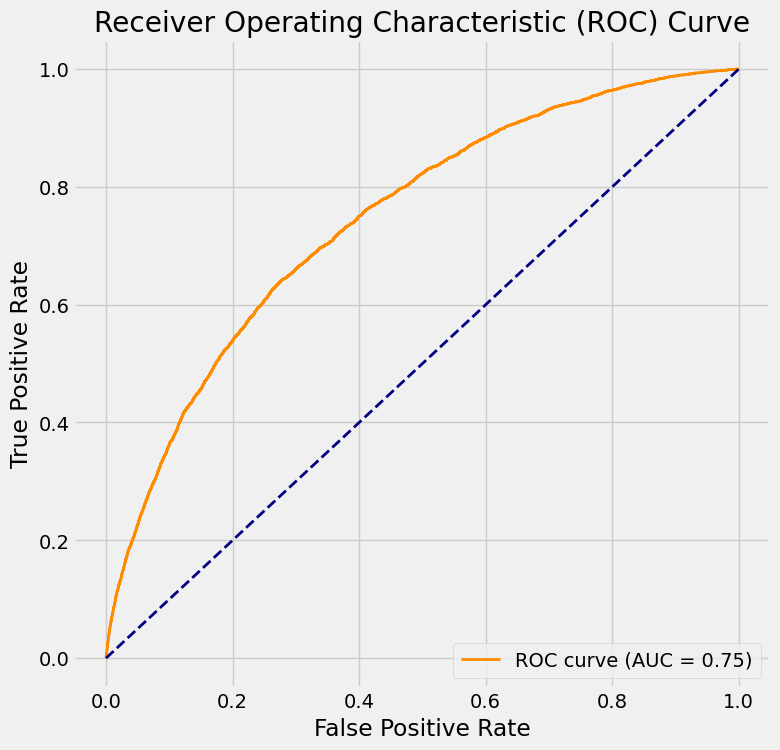

In [20]:
# Define the pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    #('imputer', SimpleImputer(strategy='median')),
    ('classifier', LogisticRegression(random_state=42))
])

# Name of the experiment
experiment_name = "logistic_regression"

# Set the experiment name
mlflow.set_experiment(experiment_name)

# Log the model parameters in MLFlow
with mlflow.start_run(run_name="baseline"):
    
    # Log specific parameters for this experiment
    mlflow.log_param("imputer_strategy", "median")
    mlflow.log_param("scaler", "MinMaxScaler")
    mlflow.log_param("classifier", "LogisticRegression")
    
    # Train the model
    pipeline.fit(X_train, y_train)
    
    # Predict on the test set
    y_pred_proba = pipeline.predict_proba(X_test)[:, 1]
    y_pred = (y_pred_proba > 0.5).astype(int)  # Threshold for classification

    # Calculate and print various metrics
    auc_roc = roc_auc_score(y_test, y_pred_proba)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    f_beta = fbeta_score(y_test, y_pred, beta=10)
    conf_matrix = confusion_matrix(y_test, y_pred)

    print(f'AUC ROC: {auc_roc}')
    print(f'Accuracy: {accuracy}')
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    print(f'F1 Score: {f1}')
    print(f'Fbeta Score: {f_beta}')
    print('Confusion Matrix:')
    print(conf_matrix)

    # Log the metrics in MLFlow
    mlflow.log_metric("AUC ROC", auc_roc)
    mlflow.log_metric("Accuracy", accuracy)
    mlflow.log_metric("Precision", precision)
    mlflow.log_metric("Recall", recall)
    mlflow.log_metric("F1 Score", f1)
    mlflow.log_metric("Fbeta Score", f_beta)
    
    # Plot ROC Curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 8))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")  
    # save the plot
    plt.savefig("roc_curve.png")
    # Show the plot
    plt.show()
    plt.close()
    
    # Log ROC Curve as an artifact
    mlflow.log_artifact("roc_curve.png", "roc_curve.png")
    
    # Log the model in MLFlow
    mlflow.sklearn.log_model(pipeline, "model")

**Optimisation des hyperparametres:**

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the doc

Best Threshold: 0.5151515151515152
AUC ROC: 0.7377419641799123
Accuracy: 0.7074451652764906
Precision: 0.16266680459294508
Recall: 0.6354819155384926
F1 Score: 0.25902895029444467
Fbeta Score: 0.6177051692420182
Confusion Matrix:
[[40365 16189]
 [ 1804  3145]]


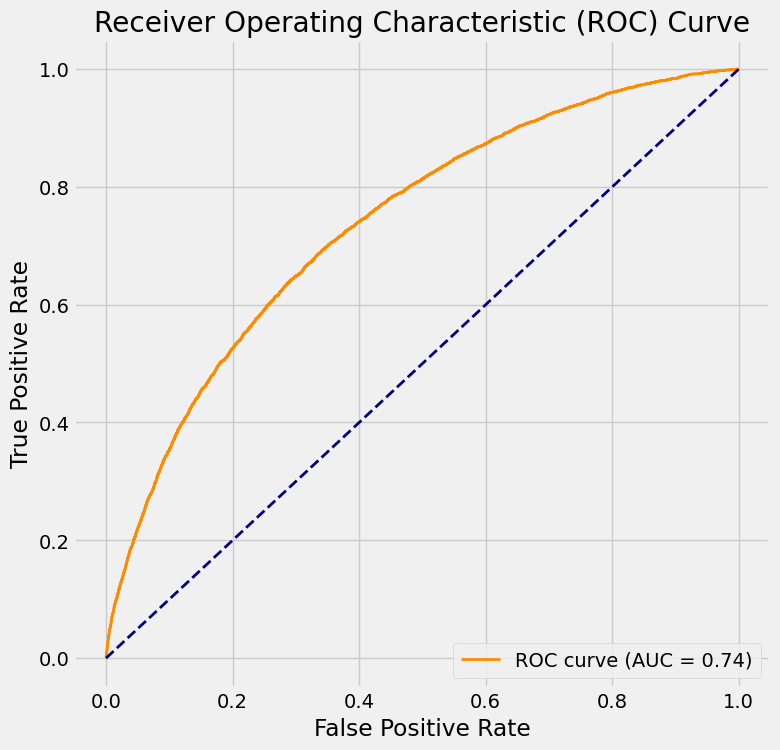

2024/02/26 12:39:11 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\PC\AppData\Local\Temp\tmpzz0z0drk\model\model.pkl, flavor: sklearn), fall back to return ['scikit-learn==1.3.0', 'cloudpickle==2.2.1']. Set logging level to DEBUG to see the full traceback.
Setuptools is replacing distutils.


In [15]:
# Define the classifiers with theirs hyperparameters
classifiers = {
    'logistic_regression': {
        'model': LogisticRegression(random_state=42),
        'params': {
            'C': [0.1, 1, 10, 100],
            'penalty': ['l1', 'l2']
            #'solver' : ['newton-cg', 'lbfgs', 'liblinear']
        }
    }
}

# Define the F-beta scorer
scorer = make_scorer(fbeta_score, beta=10)

# Define SMOTE strategies
#smote_strategies = [0.25, 0.3, 0.4]  # Corresponding to 80/20, 70/30, and 60/40 ratios

# Train the models
for classifier_name, classifier_info in classifiers.items():
    
    # Name of the experiment in MLFlow
    mlflow.set_experiment(classifier_name)
    
    # Use StratifiedKFold for cross-validation
    #skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    # GridSearchCV with StratifiedKFold
    #grid_search = GridSearchCV(
        #classifier_info['model'], 
        #classifier_info['params'], 
        #cv=skf,  # Use StratifiedKFold
        #scoring=scorer
        #) 

    # Define the pipeline with resampling an Gridsearch
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('smote', SMOTE(random_state=42)),
        ('classifier', GridSearchCV(classifier_info['model'], classifier_info['params'], cv=5, scoring=scorer))
        #('classifier', grid_search)
    ])
        
    # Log the model parameters in MLFlow
    with mlflow.start_run(run_name=f"{classifier_name}_hyperparameter_tuning"):
        # Log specific parameters for this experiment
        mlflow.log_param("imputer_strategy", "median")
        mlflow.log_param("scaler", "MinMaxScaler")
        mlflow.log_param("classifier", classifier_name)
        mlflow.log_param("resampling_technique", "SMOTE")  # Log the resampling technique
        #mlflow.log_param("sampling_strategy", smote_strategy)  # Log the SMOTE strategy
        
        # Train the model
        pipeline.fit(X_train, y_train)
        
        # Define the best hyperparameters
        best_params = pipeline.named_steps['classifier'].best_params_
        
        # Log the best hyperparameters in MLFlow
        mlflow.log_param(f"best_params_{classifier_name}", best_params)
        
        # Predict on the test set
        y_pred_proba = pipeline.predict_proba(X_test)[:, 1]
        
        # Define the cost of FP and FN
        cost_fp = 1  # Cost of false positive
        cost_fn = 10  # Cost of false negative

        # Calculate the cost for each threshold
        thresholds = np.linspace(0, 1, 100)
        best_threshold = 0
        min_total_cost = float('inf')

        for threshold in thresholds:
            y_pred = (y_pred_proba > threshold).astype(int)
            tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
            total_cost = (cost_fp * fp) + (cost_fn * fn)
    
            # Update best threshold if the total cost is mini
            if total_cost < min_total_cost:
                min_total_cost = total_cost
                best_threshold = threshold
        
        print(f"Best Threshold: {best_threshold}")
        
        # Optimize threshold for classification
        #thresholds = np.linspace(0.1, 0.9, 20)
        #best_threshold = 0.5
        #best_score = 0
        #for threshold in thresholds:
            #y_pred = (y_pred_proba > threshold).astype(int)
            #f_beta = fbeta_score(y_test, y_pred, beta=10)
            #if f_beta > best_score:
                #best_score = f_beta
                #best_threshold = threshold
        
        # Use the best threshold
        y_pred = (y_pred_proba > best_threshold).astype(int)  # Threshold for classification
          
        # Calculate and print various metrics
        auc_roc = roc_auc_score(y_test, y_pred_proba)
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        f_beta = fbeta_score(y_test, y_pred, beta=10)
        conf_matrix = confusion_matrix(y_test, y_pred)
        
        print(f'AUC ROC: {auc_roc}')
        print(f'Accuracy: {accuracy}')
        print(f'Precision: {precision}')
        print(f'Recall: {recall}')
        print(f'F1 Score: {f1}')
        print(f'Fbeta Score: {f_beta}')
        print('Confusion Matrix:')
        print(conf_matrix)
        
        # Log the metrics in MLFlow
        mlflow.log_metric("AUC ROC", auc_roc)
        mlflow.log_metric("Accuracy", accuracy)
        mlflow.log_metric("Precision", precision)
        mlflow.log_metric("Recall", recall)
        mlflow.log_metric("F1 Score", f1)
        mlflow.log_metric("Fbeta Score", f_beta)
        
        # Plot ROC Curve
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        
        plt.figure(figsize=(8, 8))
        plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend(loc="lower right")  
        
        # Save the plot with a dynamic filename
        roc_curve_filename = f"roc_curve_{classifier_name}.png"
        plt.savefig(roc_curve_filename)
        
        # Show the plot
        plt.show()
        plt.close()
        
        # Log ROC Curve as an artifact
        mlflow.log_artifact(roc_curve_filename, roc_curve_filename)
        
        # Log the model in MLFlow
        mlflow.sklearn.log_model(pipeline, f"model_{classifier_name}")

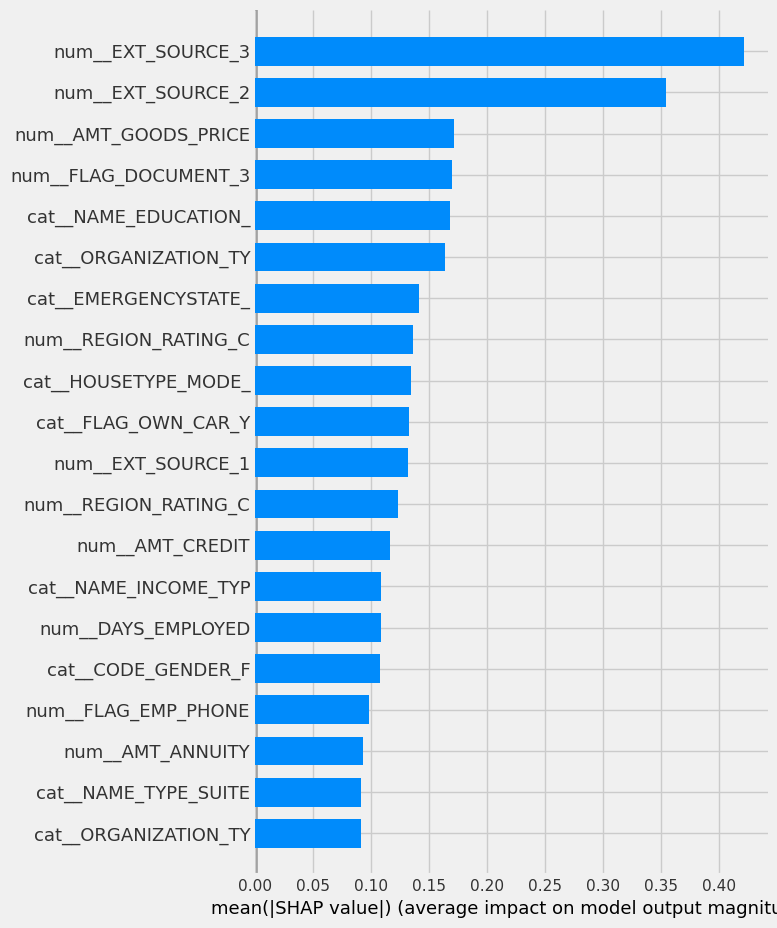

In [28]:
# SHAP analysis for global feature importance
X_train_processed = pipeline.named_steps['preprocessor'].transform(X_train)

# Get the feature names
feature_names = pipeline[:-1].get_feature_names_out()

# Create a list for short features names
short_feature_names = [name[:20] for name in feature_names]

explainer = shap.Explainer(pipeline.named_steps['classifier'].best_estimator_, X_train_processed)
shap_values = explainer.shap_values(X_train_processed)

# Plot the SHAP values
shap.summary_plot(shap_values, X_train_processed, plot_type="bar", feature_names=short_feature_names)

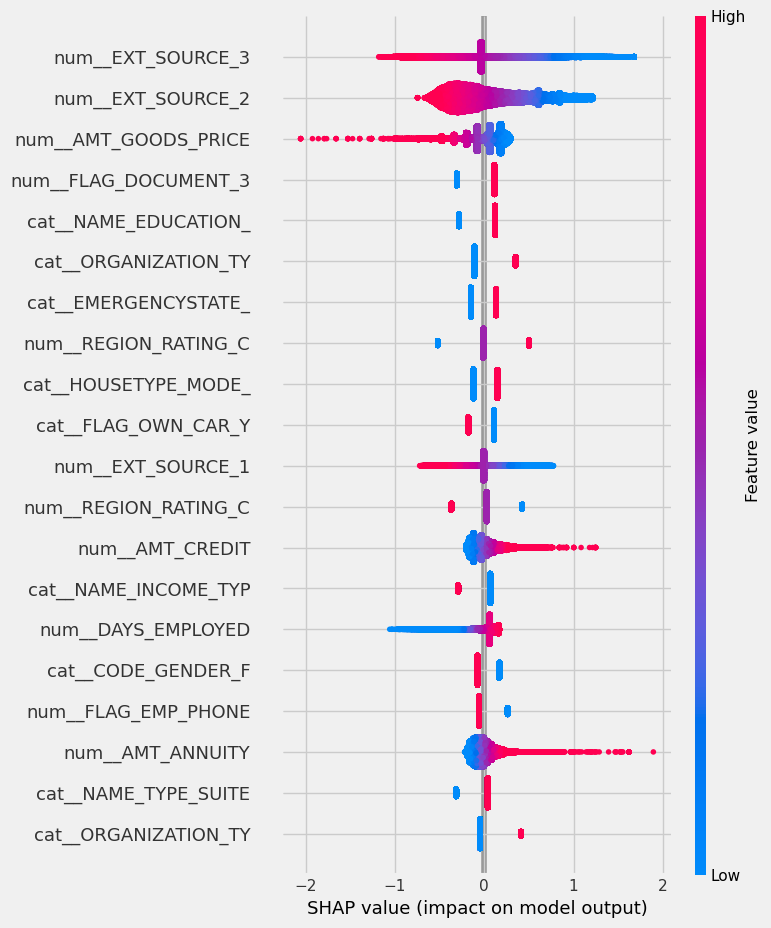

In [29]:
# Plot the SHAP values
shap.summary_plot(shap_values, X_train_processed, feature_names=short_feature_names)

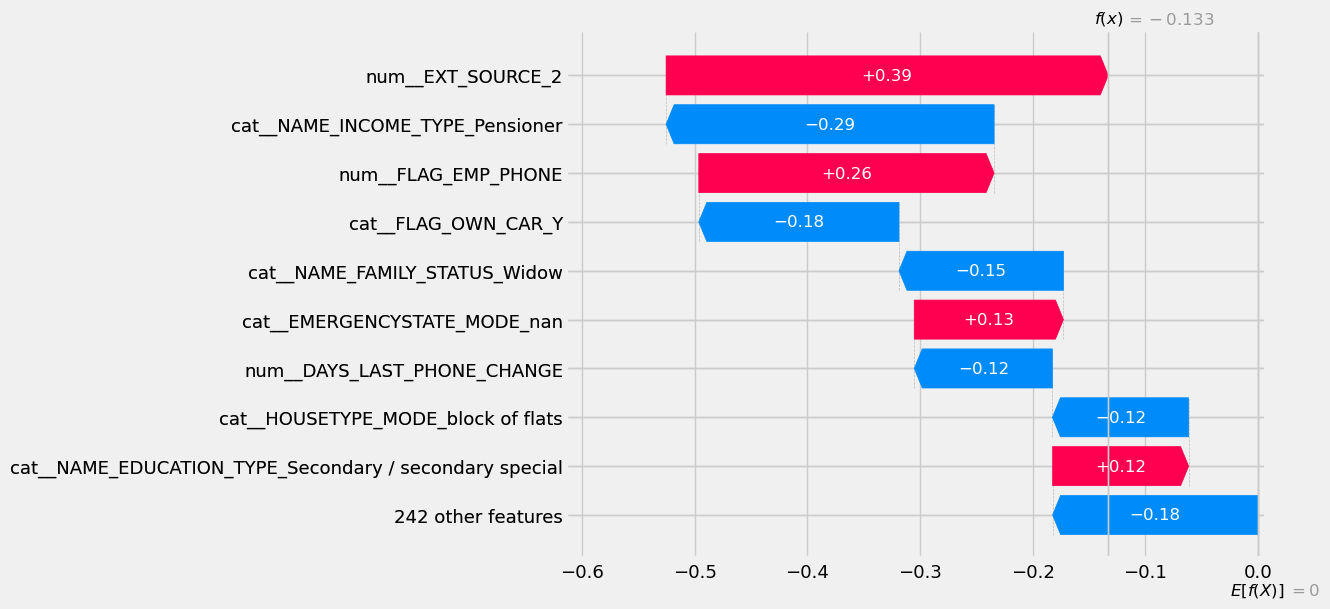

In [40]:
#waterfall plot
shap.waterfall_plot(shap.Explanation(values=shap_values[0], base_values=0, feature_names=feature_names))

In [31]:
# Choisissez un échantillon spécifique pour l'analyse
sample = X_train_processed[0]

# Calculez les valeurs SHAP pour l'échantillon
sample_shap_values = explainer.shap_values(sample)

# Affichez le diagramme de force SHAP pour l'échantillon
shap.force_plot(explainer.expected_value, sample_shap_values, sample, feature_names=short_feature_names)

In [45]:
#Stacked force plot
expected_value = explainer.expected_value
shap.plots.force(expected_value, shap_values[0:20], feature_names=feature_names)

In [17]:
model = joblib.load("model.joblib")

In [34]:
sk_id=100007

In [35]:
test =  app_train[app_train["SK_ID_CURR"] == sk_id]

In [36]:
prediction = model.predict(test)

In [37]:
prediction

array([0], dtype=int64)

In [16]:
# Sélectionner les premières 50 000 lignes
app_train_subset = app_train.head(50000)

# Enregistrer dans un fichier CSV
app_train_subset.to_csv("application_train_subset.csv", index=False)

In [3]:
!mlflow ui

^C


In [ ]:
from evidently.metric_preset import DataDriftPreset
from evidently.report import Report
import pandas as pd

# Charger les données de référence
old_data = pd.read_csv("application_train.csv")
old_data = old_data.drop('TARGET', axis=1)

# Charger les nouvelles données
new_data = pd.read_csv("application_test.csv")

# Définir le mappage des colonnes
column_mapping = None  # Remplacez par votre mappage de colonnes

# Créer un rapport avec DataDriftPreset
data_drift = Report(metrics=[DataDriftPreset()])

# Exécuter le rapport
data_drift.run(current_data=new_data,
               reference_data=old_data,
               column_mapping=column_mapping)

# Afficher le rapport
data_drift.show()

## LGBMClassifier

2024/02/20 13:29:21 INFO mlflow.tracking.fluent: Experiment with name 'lgbm' does not exist. Creating a new experiment.


[LightGBM] [Info] Number of positive: 180906, number of negative: 180905
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.429023 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 52787
[LightGBM] [Info] Number of data points in the train set: 361811, number of used features: 242
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Info] Number of positive: 180906, number of negative: 180905
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.339745 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 52493
[LightGBM] [Info] Number of data points in the train set: 361811, number of used features: 242
[LightGBM]

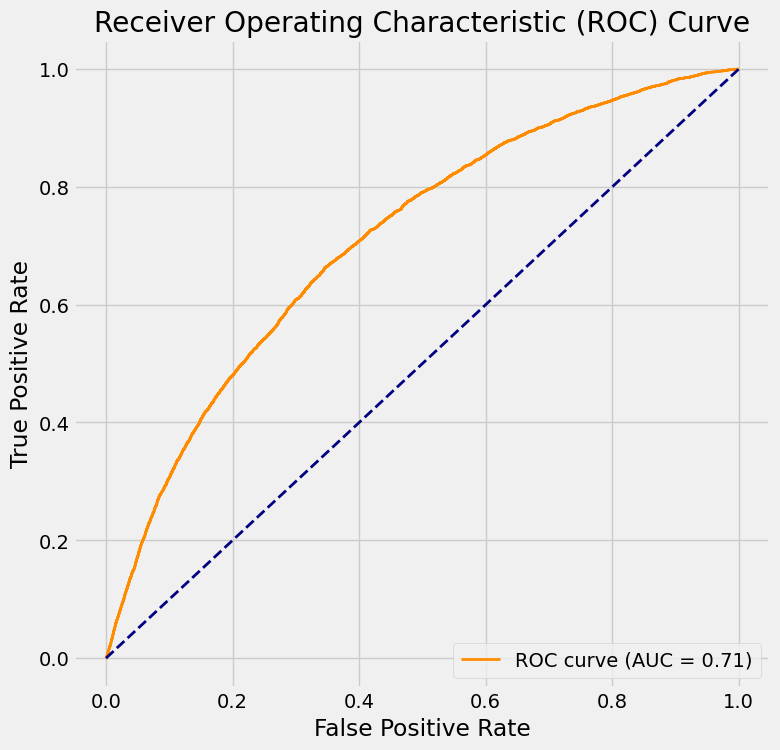

In [46]:
# Define the classifiers with theirs hyperparameters
classifiers = {
    'lgbm': {
        'model': LGBMClassifier(random_state=42),
        'params': {
            'class_weight': ['balanced'],
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.01, 0.1, 0.5],
            'num_leaves': [15, 31, 63],
            'max_depth': [3, 7, 15]
            #'subsample': [0.5, 0.75, 1.0]
        }
    }
}

# Define the F-beta scorer
scorer = make_scorer(fbeta_score, beta=10)

# Define SMOTE strategies
#smote_strategies = [0.25, 0.3, 0.4]  # Corresponding to 80/20, 70/30, and 60/40 ratios

# Train the models
for classifier_name, classifier_info in classifiers.items():
    
    # Name of the experiment in MLFlow
    mlflow.set_experiment(classifier_name)
    
    # Use StratifiedKFold for cross-validation
    #skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    # GridSearchCV with StratifiedKFold
    #grid_search = GridSearchCV(
        #classifier_info['model'], 
        #classifier_info['params'], 
        #cv=skf,  # Use StratifiedKFold
        #scoring=scorer
        #) 

    # Define the pipeline with resampling an Gridsearch
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('smote', SMOTE(random_state=42)),
        ('classifier', GridSearchCV(classifier_info['model'], classifier_info['params'], cv=5, scoring=scorer))
        #('classifier', grid_search)
    ])
        
    # Log the model parameters in MLFlow
    with mlflow.start_run(run_name="{classifier_name}_hyperparameter_tuning"):
        # Log specific parameters for this experiment
        mlflow.log_param("imputer_strategy", "median")
        mlflow.log_param("scaler", "MinMaxScaler")
        mlflow.log_param("classifier", classifier_name)
        mlflow.log_param("resampling_technique", "SMOTE")  # Log the resampling technique
        #mlflow.log_param("sampling_strategy", smote_strategy)  # Log the SMOTE strategy
        
        # Train the model
        pipeline.fit(X_train, y_train)
        
        # Define the best hyperparameters
        best_params = pipeline.named_steps['classifier'].best_params_
        
        # Log the best hyperparameters in MLFlow
        mlflow.log_param(f"best_params_{classifier_name}", best_params)
        
        # Predict on the test set
        y_pred_proba = pipeline.predict_proba(X_test)[:, 1]
        
        # Define the cost of FP and FN
        cost_fp = 1  # Cost of false positive
        cost_fn = 10  # Cost of false negative

        # Calculate the cost for each threshold
        thresholds = np.linspace(0, 1, 100)
        best_threshold = 0
        min_total_cost = float('inf')

        for threshold in thresholds:
            y_pred = (y_pred_proba > threshold).astype(int)
            tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
            total_cost = (cost_fp * fp) + (cost_fn * fn)
    
            # Update best threshold if the total cost is mini
            if total_cost < min_total_cost:
                min_total_cost = total_cost
                best_threshold = threshold
        
        print(f"Best Threshold: {best_threshold}")
        
        # Optimize threshold for classification
        #thresholds = np.linspace(0.1, 0.9, 20)
        #best_threshold = 0.5
        #best_score = 0
        #for threshold in thresholds:
            #y_pred = (y_pred_proba > threshold).astype(int)
            #f_beta = fbeta_score(y_test, y_pred, beta=10)
            #if f_beta > best_score:
                #best_score = f_beta
                #best_threshold = threshold
        
        # Use the best threshold
        y_pred = (y_pred_proba > best_threshold).astype(int)  # Threshold for classification
          
        # Calculate and print various metrics
        auc_roc = roc_auc_score(y_test, y_pred_proba)
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        f_beta = fbeta_score(y_test, y_pred, beta=10)
        conf_matrix = confusion_matrix(y_test, y_pred)
        
        print(f'AUC ROC: {auc_roc}')
        print(f'Accuracy: {accuracy}')
        print(f'Precision: {precision}')
        print(f'Recall: {recall}')
        print(f'F1 Score: {f1}')
        print(f'Fbeta Score: {f_beta}')
        print('Confusion Matrix:')
        print(conf_matrix)
        
        # Log the metrics in MLFlow
        mlflow.log_metric("AUC ROC", auc_roc)
        mlflow.log_metric("Accuracy", accuracy)
        mlflow.log_metric("Precision", precision)
        mlflow.log_metric("Recall", recall)
        mlflow.log_metric("F1 Score", f1)
        mlflow.log_metric("Fbeta Score", f_beta)
        
        # Plot ROC Curve
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        
        plt.figure(figsize=(8, 8))
        plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend(loc="lower right")  
        
        # Save the plot with a dynamic filename
        roc_curve_filename = f"roc_curve_{classifier_name}.png"
        plt.savefig(roc_curve_filename)
        
        # Show the plot
        plt.show()
        plt.close()
        
        # Log ROC Curve as an artifact
        mlflow.log_artifact(roc_curve_filename, roc_curve_filename)
        
        # Log the model in MLFlow
        mlflow.sklearn.log_model(pipeline, f"model_{classifier_name}")

2024/02/13 11:51:57 INFO mlflow.tracking.fluent: Experiment with name 'logistic_regression' does not exist. Creating a new experiment.
C:\Users\PC\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\PC\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the document

AUC ROC: 0.7377419641799123
Accuracy: 0.6915597613124563
Precision: 0.15764027933779362
Recall: 0.6522529804000808
F1 Score: 0.25391331707700776
Fbeta Score: 0.6326009891787954
Confusion Matrix:
[[39305 17249]
 [ 1721  3228]]


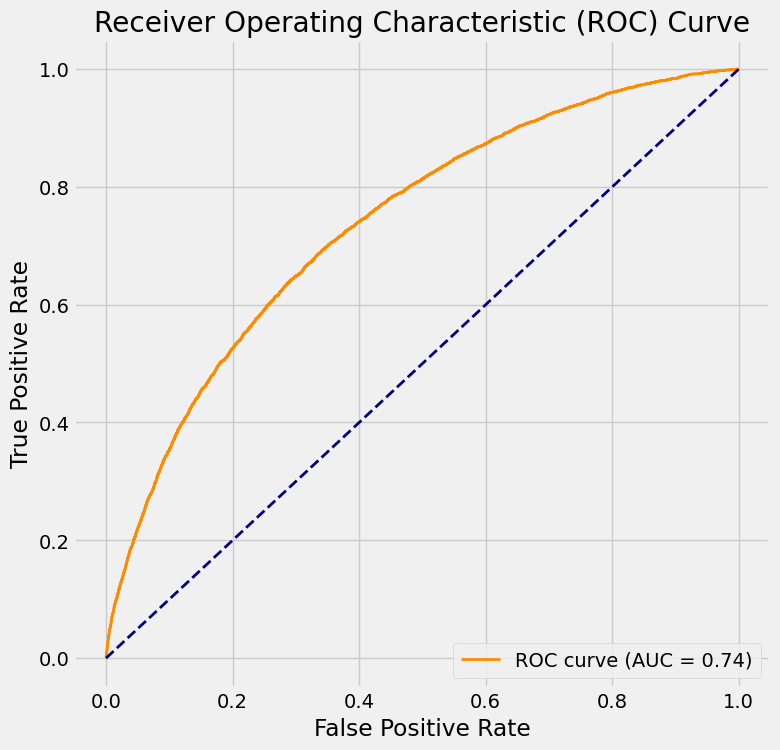

2024/02/13 12:02:06 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\PC\AppData\Local\Temp\tmpidlqrw11\model\model.pkl, flavor: sklearn), fall back to return ['scikit-learn==1.3.0', 'cloudpickle==2.2.1']. Set logging level to DEBUG to see the full traceback.
2024/02/13 12:02:08 INFO mlflow.tracking.fluent: Experiment with name 'lgbm' does not exist. Creating a new experiment.


[LightGBM] [Info] Number of positive: 180906, number of negative: 180905
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.448818 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 52787
[LightGBM] [Info] Number of data points in the train set: 361811, number of used features: 242
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Info] Number of positive: 180906, number of negative: 180905
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.651537 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 52493
[LightGBM] [Info] Number of data points in the train set: 361811, number of used features: 242
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.00

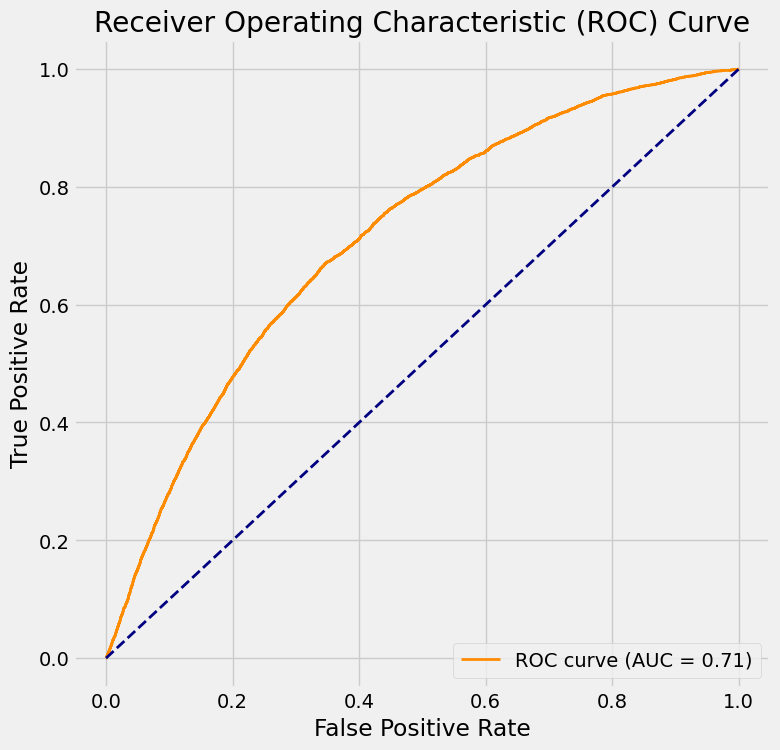

In [20]:
# Define the classifiers with theirs hyperparameters
classifiers = {
    'logistic_regression': {
        'model': LogisticRegression(random_state=42),
        'params': {
            'C': [0.1, 1, 10, 100],
            'penalty': ['l1', 'l2']
            #'solver' : ['newton-cg', 'lbfgs', 'liblinear']
        }
    },
    'lgbm': {
        'model': LGBMClassifier(random_state=42),
        'params': {
            'class_weight': ['balanced'],
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.01, 0.1, 0.5],
            'num_leaves': [15, 31, 63],
            #'max_depth': [3, 7, 15],
            #'subsample': [0.5, 0.75, 1.0]
        }
    }
    #'catboost': {
        #'model': CatBoostClassifier(random_state=42),
        #'params': {
            #'iterations': [100, 500, 1000],
            #'learning_rate': [0.001, 0.01, 0.1]
        #}
    #}
   # 'xgboost': {
        #'model': XGBClassifier(random_state=42),
        #'params': {
         #   'max_depth': [3, 5, 7],
         #   'learning_rate': [0.001, 0.01, 0.1]
      #  }
    #}
}

# Define the F-beta scorer
scorer = make_scorer(fbeta_score, beta=10)

# Train the models
for classifier_name, classifier_info in classifiers.items():
    
    # Name of the experiment in MLFlow
    mlflow.set_experiment(classifier_name)
    
    # Use StratifiedKFold for cross-validation
    #skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    # GridSearchCV with StratifiedKFold
    #grid_search = GridSearchCV(
        #classifier_info['model'], 
        #classifier_info['params'], 
        #cv=skf,  # Use StratifiedKFold
        #scoring=scorer
        #)  
    
    # Define the pipeline with resampling an Gridsearch
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        #('imputer', SimpleImputer(strategy='median')),
        ('smote', SMOTE(#statergy à rajouter, random_state=42)),
        ('classifier', GridSearchCV(classifier_info['model'], classifier_info['params'], cv=5, scoring=scorer))
        #('classifier', grid_search) 
    ])
    
    # Log the model parameters in MLFlow
    with mlflow.start_run(run_name="hyperparameter_tuning"):
        # Log specific parameters for this experiment
        mlflow.log_param("imputer_strategy", "median")
        mlflow.log_param("scaler", "MinMaxScaler")
        mlflow.log_param("classifier", classifier_name)
        mlflow.log_param("resampling_technique", "SMOTE")  # Log the resampling technique
        
        # Train the model
        pipeline.fit(X_train, y_train)
        
        # Define the best hyperparameters
        best_params = pipeline.named_steps['classifier'].best_params_
        
        # Log the best hyperparameters in MLFlow
        mlflow.log_param(f"best_params_{classifier_name}", best_params)
        
        # Predict on the test set
        y_pred_proba = pipeline.predict_proba(X_test)[:, 1]
        y_pred = (y_pred_proba > 0.5).astype(int)  # Threshold for classification
          
        # Calculate and print various metrics
        auc_roc = roc_auc_score(y_test, y_pred_proba)
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        f_beta = fbeta_score(y_test, y_pred, beta=10)
        conf_matrix = confusion_matrix(y_test, y_pred)
        
        print(f'AUC ROC: {auc_roc}')
        print(f'Accuracy: {accuracy}')
        print(f'Precision: {precision}')
        print(f'Recall: {recall}')
        print(f'F1 Score: {f1}')
        print(f'Fbeta Score: {f_beta}')
        print('Confusion Matrix:')
        print(conf_matrix)
        
        # Log the metrics in MLFlow
        mlflow.log_metric("AUC ROC", auc_roc)
        mlflow.log_metric("Accuracy", accuracy)
        mlflow.log_metric("Precision", precision)
        mlflow.log_metric("Recall", recall)
        mlflow.log_metric("F1 Score", f1)
        mlflow.log_metric("Fbeta Score", f_beta)
        
        # Plot ROC Curve
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        
        plt.figure(figsize=(8, 8))
        plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend(loc="lower right")  
        
        # Save the plot with a dynamic filename
        roc_curve_filename = f"roc_curve_{classifier_name}.png"
        plt.savefig(roc_curve_filename)
        
        # Show the plot
        plt.show()
        plt.close()
        
        # Log ROC Curve as an artifact
        mlflow.log_artifact(roc_curve_filename, roc_curve_filename)
        
        # Log the model in MLFlow
        mlflow.sklearn.log_model(pipeline, f"model_{classifier_name}")

In [76]:
# Define the classifiers with theirs hyperparameters
classifiers = {
    'lgbm': {
        'model': LGBMClassifier(random_state=42),
        'params': {
            'class_weight': ['balanced'],
            'n_estimators': [50, 100, 200],
            #'learning_rate': [0.01, 0.1, 0.5],
            'num_leaves': [15, 44, 45],
            'max_depth': [3, 8, 9],
            'min_child_weight': [3, 5, 6],
            'subsample': [0.5, 0.85, 1.0]
            
        }
    }

}

# Define the F-beta scorer
scorer = make_scorer(fbeta_score, beta=10)

# Train the models
for classifier_name, classifier_info in classifiers.items():
    
    # Name of the experiment in MLFlow
    mlflow.set_experiment(classifier_name)
    
    # Use StratifiedKFold for cross-validation
    #skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    # GridSearchCV with StratifiedKFold
    #grid_search = GridSearchCV(
        #classifier_info['model'], 
        #classifier_info['params'], 
        #cv=skf,  # Use StratifiedKFold
        #scoring=scorer
        #)  
    
    # Define the pipeline with resampling an Gridsearch
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        #('imputer', SimpleImputer(strategy='median')),
        ('smote', SMOTE(random_state=42)),
        ('classifier', GridSearchCV(classifier_info['model'], classifier_info['params'], cv=5, scoring=scorer))
        #('classifier', grid_search) 
    ])
    
    # Log the model parameters in MLFlow
    with mlflow.start_run(run_name="hyperparameter_tuning"):
        # Log specific parameters for this experiment
        mlflow.log_param("imputer_strategy", "median")
        mlflow.log_param("scaler", "MinMaxScaler")
        mlflow.log_param("classifier", classifier_name)
        mlflow.log_param("resampling_technique", "SMOTE")  # Log the resampling technique
        
        # Train the model
        pipeline.fit(X_train, y_train)
        
        # Define the best hyperparameters
        best_params = pipeline.named_steps['classifier'].best_params_
        
        # Log the best hyperparameters in MLFlow
        mlflow.log_param(f"best_params_{classifier_name}", best_params)
        
        # Predict on the test set
        y_pred_proba = pipeline.predict_proba(X_test)[:, 1]
        y_pred = (y_pred_proba > 0.5).astype(int)  # Threshold for classification
          
        # Calculate and print various metrics
        auc_roc = roc_auc_score(y_test, y_pred_proba)
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        f_beta = fbeta_score(y_test, y_pred, beta=10)
        conf_matrix = confusion_matrix(y_test, y_pred)
        
        print(f'AUC ROC: {auc_roc}')
        print(f'Accuracy: {accuracy}')
        print(f'Precision: {precision}')
        print(f'Recall: {recall}')
        print(f'F1 Score: {f1}')
        print(f'Fbeta Score: {f_beta}')
        print('Confusion Matrix:')
        print(conf_matrix)
        
        # Log the metrics in MLFlow
        mlflow.log_metric("AUC ROC", auc_roc)
        mlflow.log_metric("Accuracy", accuracy)
        mlflow.log_metric("Precision", precision)
        mlflow.log_metric("Recall", recall)
        mlflow.log_metric("F1 Score", f1)
        mlflow.log_metric("Fbeta Score", f_beta)
        
        # Plot ROC Curve
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        
        plt.figure(figsize=(8, 8))
        plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend(loc="lower right")  
        
        # Save the plot with a dynamic filename
        roc_curve_filename = f"roc_curve_{classifier_name}.png"
        plt.savefig(roc_curve_filename)
        
        # Show the plot
        plt.show()
        plt.close()
        
        # Log ROC Curve as an artifact
        mlflow.log_artifact(roc_curve_filename, roc_curve_filename)
        
        # Log the model in MLFlow
        mlflow.sklearn.log_model(pipeline, f"model_{classifier_name}")

[LightGBM] [Info] Number of positive: 180906, number of negative: 180905
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.449070 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 52787
[LightGBM] [Info] Number of data points in the train set: 361811, number of used features: 242
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Info] Number of positive: 180906, number of negative: 180905
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.654816 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 52493
[LightGBM] [Info] Number of data points in the train set: 361811, number of used features: 242
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.00


KeyboardInterrupt



In [ ]:
# Define the hyperparameter search space for each classifier
classifiers = {
    #'logistic_regression': {
        #'model': LogisticRegression(random_state=42),
        #'space': {
            #'C': hp.choice('C', [0.1, 1, 10, 100]),
            #'penalty': hp.choice('penalty', ['l1', 'l2']),
            #'solver': hp.choice('solver', ['saga', 'liblinear'])
        #}
    #}
    'lgbm': {
        'model': LGBMClassifier(random_state=42),
        'space': {
            #'n_estimators': hp.quniform('n_estimators', 50, 200, 1),
            #'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.5)),
            #'num_leaves': hp.quniform('num_leaves', 15, 63, 1),
            #'max_depth': hp.quniform('max_depth', 3, 15, 1),
            'n_estimators': hp.quniform('n_estimators', 1000, 10000, 1000),
            'max_depth' : hp.quniform('max_depth', 2, 30, 5),
            'num_leaves': hp.quniform('num_leaves', 4, 40, 4),
            'learning_rate': hp.loguniform('learning_rate', np.log(0.005), np.log(0.2)),
            #'n_estimators': hp.quniform('n_estimators', 200, 2000, 200),
            #'max_depth' : hp.quniform('max_depth', 2, 30, 2),
            #'learning_rate': hp.loguniform('learning_rate', np.log(0.005), np.log(0.2)),
            #'num_iterations': hp.quniform('num_iterations', 10, 100, 10)
            #'subsample': hp.uniform('subsample', 0.5, 1.0),
            #'class_weight': hp.choice('class_weight', [None, 'balanced'])
        }
    }
}

# Define the F-beta scorer
scorer = make_scorer(fbeta_score, beta=10)

# Objective function to minimize (negative Fbeta score)
def objective(params):
    # The pipeline
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('smote', SMOTE(random_state=42)),
        ('classifier', clone(classifier_info['model']).set_params(**params))
    ])
    score = cross_val_score(pipeline, X_train, y_train, cv=5, scoring=scorer).mean()
    return {'loss': -score, 'status': STATUS_OK}

# Optimize hyperparameters for each classifier
for classifier_name, classifier_info in classifiers.items():
    
    # Name of the experiment in MLFlow
    mlflow.set_experiment(classifier_name)
    
    # Use hyperopt to search for best hyperparameters
    trials = Trials()
    best = fmin(fn=objective,
                space=classifier_info['space'],
                algo=tpe.suggest,
                max_evals=5,
                trials=trials)
                #rstate=np.random.RandomState(seed=42)
                #rstate=np.random.default_rng(seed=42))
    
    best_params = space_eval(classifier_info['space'], best)
    
    # Define the pipeline with best hyperparameters
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('smote', SMOTE(random_state=42)),
        ('classifier', clone(classifier_info['model']).set_params(**best_params))
    ])
    
    # Train the model
    pipeline.fit(X_train, y_train)
    
    # Predict on the test set
    y_pred_proba = pipeline.predict_proba(X_test)[:, 1]
    y_pred = (y_pred_proba > 0.5).astype(int)  # Threshold for classification
    
    # Calculate and print various metrics
    auc_roc = roc_auc_score(y_test, y_pred_proba)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    f_beta = fbeta_score(y_test, y_pred, beta=10)
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    print(f'AUC ROC: {auc_roc}')
    print(f'Accuracy: {accuracy}')
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    print(f'F1 Score: {f1}')
    print(f'Fbeta Score: {f_beta}')
    print('Confusion Matrix:')
    print(conf_matrix)
    
    # Log the metrics in MLFlow
    mlflow.log_metric("AUC ROC", auc_roc)
    mlflow.log_metric("Accuracy", accuracy)
    mlflow.log_metric("Precision", precision)
    mlflow.log_metric("Recall", recall)
    mlflow.log_metric("F1 Score", f1)
    mlflow.log_metric("Fbeta Score", f_beta)
    
    # Plot ROC Curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
        
    plt.figure(figsize=(8, 8))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")  
        
    # Save the plot with a dynamic filename
    roc_curve_filename = f"roc_curve_{classifier_name}.png"
    plt.savefig(roc_curve_filename)
        
    # Show the plot
    plt.show()
    plt.close()
    
    # Log ROC Curve as an artifact
    mlflow.log_artifact(roc_curve_filename, roc_curve_filename)
    
    # Log the model in MLFlow
    mlflow.sklearn.log_model(pipeline, f"model_{classifier_name}")

In [27]:
# Define the costs
cost_fn = 10  # Cost of false negative
cost_fp = 1   # Cost of false positive

# Calculate various metrics
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Calculate the cost for each threshold
costs = cost_fn * fpr + cost_fp * (1 - tpr)

# Find the threshold that minimizes the cost
best_threshold_index = np.argmin(costs)
best_threshold = thresholds[best_threshold_index]

In [28]:
best_threshold

0.6197445232485174

In [123]:
from scipy.optimize import minimize_scalar
from sklearn.metrics import fbeta_score

# Define beta
beta = 10

# Define the cost function based on the F1 beta score
def cost_function(threshold, y_test, y_pred_proba, beta):
    y_pred = (y_pred_proba > threshold).astype(int)
    f_beta = fbeta_score(y_test, y_pred, beta=beta)
    # Use the F1 beta score to define the function cost
    cost = - f_beta
    return cost

# Find the optimal threshold
result = minimize_scalar(cost_function, bounds=(0, 1), args=(y_test, y_pred_proba, beta), method='bounded')
optimal_threshold = result.x

# Print the optimal threshold
print(f'Optimal Threshold : {optimal_threshold}')

Optimal Threshold : 0.012455199206586009


In [112]:
cost_fn = 10  # Coût d'un faux négatif
cost_fp = 1   # Coût d'un faux positif

def calculate_cost(y_test, y_pred_proba, threshold, cost_fn, cost_fp):
    y_pred = (y_pred_proba > threshold).astype(int)
    fn = np.sum((y_test == 1) & (y_pred == 0))
    fp = np.sum((y_test == 0) & (y_pred == 1))
    total_cost = fn * cost_fn + fp * cost_fp
    return total_cost

def find_optimal_threshold(y_test, y_pred_proba, cost_fn, cost_fp):
    cost_function = lambda threshold: calculate_cost(y_test, y_pred_proba, threshold, cost_fn, cost_fp)
    result = minimize_scalar(cost_function, bounds=(0, 1), method='bounded')
    optimal_threshold = result.x
    return optimal_threshold
# Print the optimal threshold
optimal_threshold = find_optimal_threshold(y_test, y_pred_proba, cost_fn, cost_fp)
print(f'Optimal Threshold : {optimal_threshold}')

Optimal Threshold : 0.08985157532180978


In [14]:
!mlflow ui

^C


In [41]:
# Drop the target from the training data
if 'TARGET' in app_train:
    train = app_train.drop(columns = ['TARGET'])
else:
    train = app_train.copy()
    
# Feature names
features = list(train.columns)

# Copy of the testing data
test = app_test.copy()

# Median imputation of missing values
imputer = SimpleImputer(strategy = 'median')

# Fit on the training data
imputer.fit(train)

# Transform both training and testing data
train = imputer.transform(train)
test = imputer.transform(app_test)

print('Training data shape: ', train.shape)
print('Testing data shape: ', test.shape)

Training data shape:  (307511, 240)
Testing data shape:  (48744, 240)


In [ ]:
# Drop the target from the training data
if 'TARGET' in app_train:
    train = app_train.drop(columns = ['TARGET'])
else:
    train = app_train.copy()
    
# Feature names
features = list(train.columns)

# Copy of the testing data
test = app_test.copy()

# Median imputation of missing values
imputer = SimpleImputer(strategy = 'median')

# Scale each feature to 0-1
scaler = MinMaxScaler(feature_range = (0, 1))

# Fit on the training data
imputer.fit(train)

# Transform both training and testing data
train = imputer.transform(train)
test = imputer.transform(app_test)

# Repeat with the scaler
scaler.fit(train)
train = scaler.transform(train)
test = scaler.transform(test)

print('Training data shape: ', train.shape)
print('Testing data shape: ', test.shape)

* **LogisticRegression :**

In [63]:
# Make the model with the specified regularization parameter
log_reg = LogisticRegression(C = 0.0001)

# Train on the training data
log_reg.fit(train, train_labels)

LogisticRegression(C=0.0001)

Nous voulons prédire les probabilités de non-remboursement d’un prêt, donc nous utilisons la méthode predict.proba du modèle.

Cette méthode renvoie un tableau de m x 2 où m est le nombre d’observations. La première colonne est la probabilité que la cible soit 0 et la deuxième colonne est la probabilité que la cible soit 1. Nous voulons la probabilité que le prêt ne soit pas remboursé, donc nous sélectionnerons la 2ème colonne.

In [68]:
# Make predictions
log_reg_pred = log_reg.predict_proba(test)[:, 1]

Les prédictions doivent être au format indiqué dans le fichier sample_submission.csv, où il n’y a que deux colonnes : SK_ID_CURR et TARGET. Nous allons créer un dataframe dans ce format à partir de l’ensemble de test et des prédictions.

In [69]:
# Submission dataframe
submit = app_test[['SK_ID_CURR']]
submit['TARGET'] = log_reg_pred

submit.head()

C:\Users\PC\AppData\Local\Temp\ipykernel_14304\3983587544.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  submit['TARGET'] = log_reg_pred


,SK_ID_CURR,TARGET
0,100001,0.078548
1,100005,0.137968
2,100013,0.082238
3,100028,0.080937
4,100038,0.132964


In [94]:
# LightGBM GBDT with KFold or Stratified KFold
def kfold_lightgbm(train_df, test_df, num_folds, stratified = False, debug= False):
    train_df = train_df.rename(columns=lambda x: re.sub('[^A-Za-z0-9_]+', '', x))
    test_df = test_df.rename(columns=lambda x: re.sub('[^A-Za-z0-9_]+', '', x))
    print("Starting LightGBM. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))
    # Cross validation model
    if stratified:
        folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=1001)
    else:
        folds = KFold(n_splits= num_folds, shuffle=True, random_state=1001)
    # Create arrays and dataframes to store results
    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])
    feature_importance_df = pd.DataFrame()
    feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
        train_x, train_y = train_df[feats].iloc[train_idx], train_df['TARGET'].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx]

        # LightGBM parameters found by Bayesian optimization
        clf = LGBMClassifier(
            nthread=4,
            n_estimators=10000,
            learning_rate=0.02,
            num_leaves=34,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            max_depth=8,
            reg_alpha=0.041545473,
            reg_lambda=0.0735294,
            min_split_gain=0.0222415,
            min_child_weight=39.3259775,
            silent=-1,
            verbose=-1,
            early_stopping_rounds=200)

        clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)],
                eval_metric= 'auc')

        oof_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]
        sub_preds += clf.predict_proba(test_df[feats], num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))
        del clf, train_x, train_y, valid_x, valid_y

    print('Full AUC score %.6f' % roc_auc_score(train_df['TARGET'], oof_preds))

In [95]:
kfold_lightgbm(app_train, app_test, 5)

Starting LightGBM. Train shape: (307511, 241), test shape: (48744, 240)
Fold  1 AUC : 0.762851
Fold  2 AUC : 0.762484
Fold  3 AUC : 0.755555
Fold  4 AUC : 0.760177
Fold  5 AUC : 0.762684
Full AUC score 0.760748
